### О кейсе

Кейс состоит из последовательных вопросов

(отвечать на них обязательно, код и графики без интерпретации не имеют никакого смысла, **иначе - снижение баллов**), посвященных работе с табличными данными, но на более низком уровне с помощью Numpy

Баллы даются за выполнение отдельных пунктов

(Максимальное количество баллов за этот кейс - 10 (чтобы вам было проще оценивать свои успехи))

Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании.

В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Если эксперт заметит плагиат - баллы за ваше решения также снижаются.


# Кейс

## Часть 0. Подготовка [+0.5 балла]

**Задание 1 [+0.5 балла]**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'nyc-taxi-trip-duration'

nyc-taxi-trip-duration.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
! unzip nyc-taxi-trip-duration.zip -d data

Archive:  nyc-taxi-trip-duration.zip
replace data/sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mkdir sample
! mkdir test
! mkdir train

mkdir: cannot create directory ‘sample’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘train’: File exists


In [ ]:
! unzip data/sample_submission.zip -d sample
! unzip data/test.zip -d test
! unzip data/train.zip -d train

Archive:  data/sample_submission.zip
replace sample/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  data/test.zip
replace test/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  data/train.zip
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

В колонке `dropoff_datetime` содержится информация о времени окончания поездки, однако эта колонка присутствует только в обучающей выборке и отсутствует в тестовой. Это создаёт проблему, так как при обучении модели мы не сможем использовать эту колонку для предсказаний на новых данных. В связи с этим, чтобы избежать ошибок и упростить анализ, рекомендуется удалить колонку `dropoff_datetime` из датасета.

Колонка `pickup_datetime` содержит дату и время начала поездки в формате строки, что затрудняет выполнение операций с датами и временем, таких как вычисление продолжительности поездки или анализ зависимости цены от времени суток. Преобразование этих данных в `datetime`-объекты позволит использовать методы для работы с датой (вместо огромного количества строк для решения какой-нибудь маленькой подзадачи будет использоваться один вызов метода)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
fd_sample = pd.read_csv('sample/sample_submission.csv')
fd_test = pd.read_csv('test/test.csv')
fd_train = pd.read_csv('train/train.csv')

In [ ]:
fd_sample

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959
...,...,...
625129,id3008929,959
625130,id3700764,959
625131,id2568735,959
625132,id1384355,959


In [ ]:
fd_test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N


In [ ]:
fd_train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [ ]:
fd_train.drop('dropoff_datetime', axis = 1, inplace = True)

In [ ]:
fd_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [ ]:
fd_train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
fd_train['pickup_datetime'] = pd.to_datetime(fd_train.pickup_datetime)

In [ ]:
fd_train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` содержится значение, которое мы стремимся предсказать. Давайте изучим распределение целевой переменной в обучающем наборе данных. Для этого построим гистограмму этой переменной.

Построение гистограммы целевой переменной важно по нескольким причинам:

1. **Понимание распределения**: Гистограмма помогает нам увидеть, как распределены значения целевой переменной. Это может дать представление о том, является ли распределение нормальным, скошенным или имеет выбросы.

2. **Выявление аномалий**: При анализе гистограммы мы можем обнаружить аномальные значения или выбросы, которые могут повлиять на качество модели.

3. **Выбор подходящего алгоритма**: Понимание распределения целевой переменной может помочь в выборе наиболее правильного анализа датасета. Например, если данные сильно скошены, может потребоваться преобразование данных перед обучением модели. (как на практическом занятии, если у нас таргет расположен по экспоненте, то было бы классно предсказывать логарифм, а не экспоненту (подробнее было на лекции))


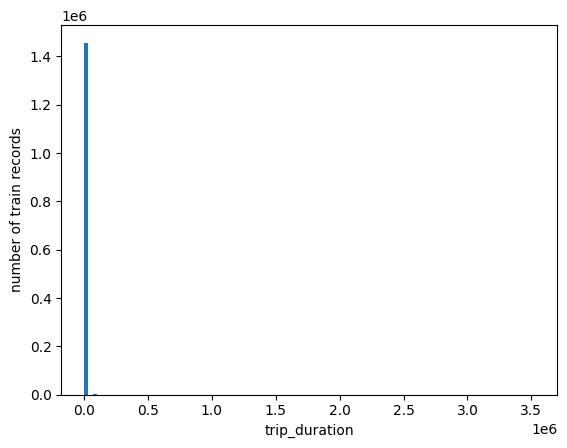

In [ ]:

plt.hist(fd_train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

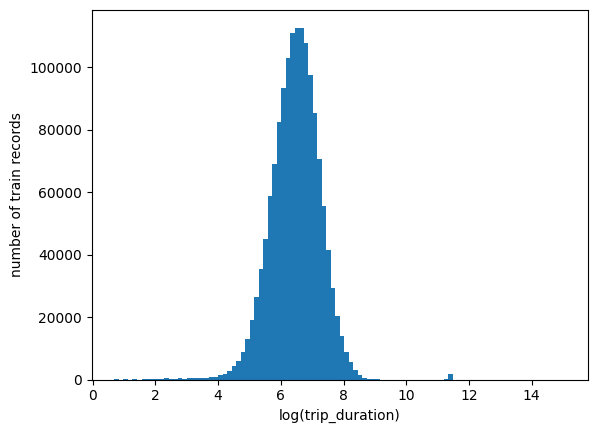

In [ ]:
fd_train['log_trip_duration'] = np.log1p(fd_train['trip_duration'].values)
plt.hist(fd_train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В целом распределение нормальное, есть небольшой выброс в правой части.

In [ ]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

В секундах: 148.4131591025766 8103.083927575384
В минутах: 2.0 135.0


In [ ]:
fd_train['trip_duration'].max() // 3600 #самая длинная поездка

979

In [ ]:
fd_train[fd_train.trip_duration >= 979 * 3600] #выброс

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
978383,id0053347,1,2016-02-13 22:46:52,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,15.075755


In [ ]:
fd_train.drop(978383, inplace=True)

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Чтобы уменьшить влияние выбросов и абсолютных значений ошибки

Мы изучили несколько вариантов линейной регрессии в sklearn, но все они минимизировали среднеквадратичную ошибку (MSE), а не среднеквадратичную логарифмическую ошибку (RMSLE). Для работы с RMSLE мы можем использовать следующий подход: вместо прямого предсказания целевой переменной, мы будем предсказывать ее логарифм. Пусть $\hat{y}_i = \log{(y_i + 1)}$ будет модифицированной целевой переменной, а $\hat{a}(x_i)$ — предсказание модели, обученной на $\hat{y}_i$. Чтобы получить исходное предсказание, мы используем обратное преобразование: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

\

Это преобразование позволяет нам оптимизировать MSE для логарифмированных значений, что эквивалентно оптимизации RMSLE для исходных значений. Это связано с тем, что минимизация квадратичной ошибки между логарифмами прогнозов и реальных значений соответствует минимизации логарифмической ошибки между самими прогнозами и реальными значениями ***(для дополнительного балла можете доказать почему)***. Таким образом, этот подход позволяет использовать стандартные методы линейной регрессии для задач, где требуется минимизировать RMSLE.






In [ ]:
fd_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

***(Какая константа прекрасно оптимизирует RMSLE MSE (с преобразованиями?))***

In [ ]:
def rmsle(log1p_y_true, log1p_y_pred):
    sq_log = np.square(log1p_y_true - log1p_y_pred)
    mean_sq_log = np.mean(sq_log)
    rmsle_value = np.sqrt(mean_sq_log)
    return rmsle_value


log1p_true_mean = np.mean(fd_train['log_trip_duration'])
rmsle_best_const = rmsle(fd_train['log_trip_duration'], log1p_true_mean)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4) # ответ конечно же нельзя подсматривать

0.7957275843058511


## Часть 1. Изучаем `pickup_datetime` & Обучаем модель [+1 балл]


**Задание 2 [+0.125 балла]**. Для начала давайте проанализируем общее количество поездок по дням. Построим график, отражающий зависимость числа поездок от конкретного дня в году (например, можно использовать `sns.countplot`).

Просмотр этой информации важен по нескольким причинам:

1. **Выявление закономерностей**: Анализ количества поездок по дням может помочь выявить определенные закономерности или тренды, например, повышенный спрос в выходные дни или праздничные периоды.

2. **Обнаружение аномалий**: График может помочь идентифицировать дни с необычно высоким или низким количеством поездок, что может указывать на наличие аномалий или особых событий.

3. **Корректировка моделей**: Если анализ показывает, что спрос сильно колеблется в зависимости от дня, это может потребовать учета этого фактора в моделях прогнозирования.

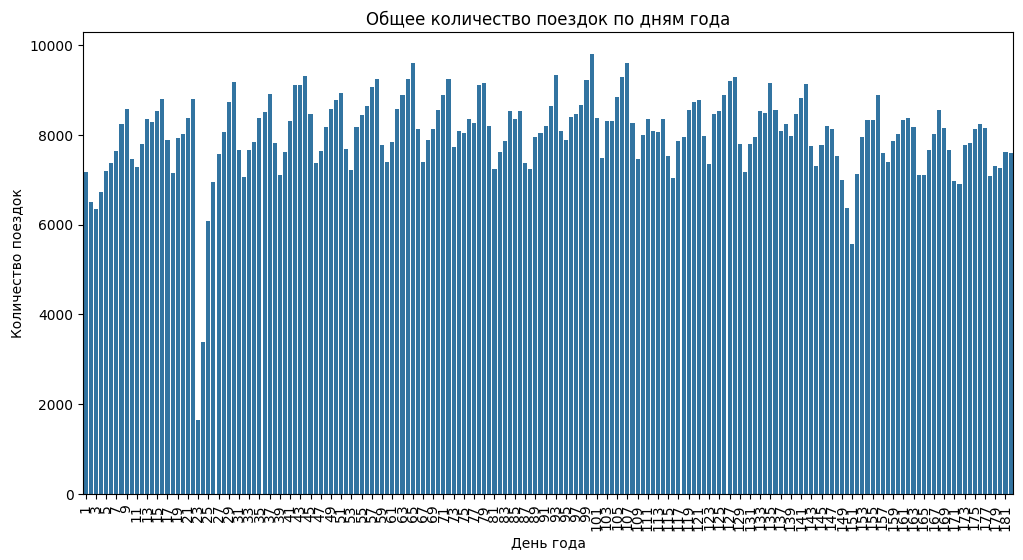

In [ ]:
plt.figure(figsize=(12, 6))
fd_train['day_of_year'] = fd_train['pickup_datetime'].dt.dayofyear
sns.countplot(data=fd_train, x='day_of_year')


plt.xticks(rotation=90)
interval = 2
plt.xticks(range(0, max(fd_train['day_of_year']), interval))


plt.xlabel('День года')
plt.ylabel('Количество поездок')
plt.title('Общее количество поездок по дням года')


plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
fd_train[fd_train['day_of_year'] == 23] # в этот день было совершено всего 1648 поездок, власти нью-йорка запретили автомобильное движение

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year
310,id1027675,2,2016-01-23 08:46:42,1,-73.969536,40.755219,-73.976524,40.747948,N,1197,7.088409,23
593,id2657420,1,2016-01-23 00:06:25,1,-73.982101,40.745903,-73.993843,40.683250,N,1290,7.163172,23
794,id3382236,2,2016-01-23 10:38:43,5,-73.975281,40.760990,-73.963181,40.767761,N,332,5.808142,23
1162,id2636301,2,2016-01-23 01:16:58,1,-74.004913,40.728310,-73.991524,40.759865,N,977,6.885510,23
3486,id0252677,2,2016-01-23 00:19:01,5,-73.993103,40.692940,-73.964149,40.672230,N,981,6.889591,23
...,...,...,...,...,...,...,...,...,...,...,...,...
1453773,id2645547,2,2016-01-23 11:36:46,1,-74.000229,40.732941,-73.988396,40.733685,N,257,5.552960,23
1455015,id1907515,2,2016-01-23 01:08:39,3,-74.006630,40.716183,-74.006630,40.716183,N,460,6.133398,23
1455913,id1950275,1,2016-01-23 03:14:57,2,-74.009132,40.713326,-73.953720,40.707829,N,1019,6.927558,23
1456874,id2600978,1,2016-01-23 00:47:43,2,-73.992233,40.725750,-73.957001,40.766415,N,910,6.814543,23


In [ ]:
fd_train[fd_train['day_of_year'] == 151] #в этот день было совершенно 5570 поездок, 9 человек пострадали от стрельбы в нью-йорке, а также день поминовения

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year
731,id0556653,2,2016-05-30 13:33:07,2,-74.000748,40.718281,-73.996140,40.690948,N,476,6.167516,151
824,id0571618,1,2016-05-30 13:08:31,2,-74.005287,40.719158,-74.015442,40.714436,N,414,6.028279,151
1173,id3018151,2,2016-05-30 12:13:20,2,-73.870880,40.773739,-73.929062,40.850849,N,1087,6.992096,151
1489,id3397528,2,2016-05-30 04:01:54,5,-73.993294,40.722450,-73.999222,40.673260,N,870,6.769642,151
1505,id0593374,1,2016-05-30 23:02:53,2,-73.776718,40.645107,-73.917183,40.700546,N,1729,7.455877,151
...,...,...,...,...,...,...,...,...,...,...,...,...
1458095,id0599121,2,2016-05-30 02:47:27,6,-73.987900,40.721050,-73.968826,40.755684,N,1116,7.018402,151
1458150,id2588416,1,2016-05-30 16:28:41,1,-73.971672,40.757324,-73.976402,40.750854,N,141,4.955827,151
1458575,id0420075,2,2016-05-30 03:52:41,1,-74.003891,40.751667,-74.001350,40.746571,N,206,5.332719,151
1458602,id2089150,1,2016-05-30 14:42:12,1,-74.015457,40.708027,-74.015396,40.708138,N,26,3.295837,151


<ipython-input-32-399406fc6280>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trips_by_day, x='day_of_week', y='trips', palette='muted')


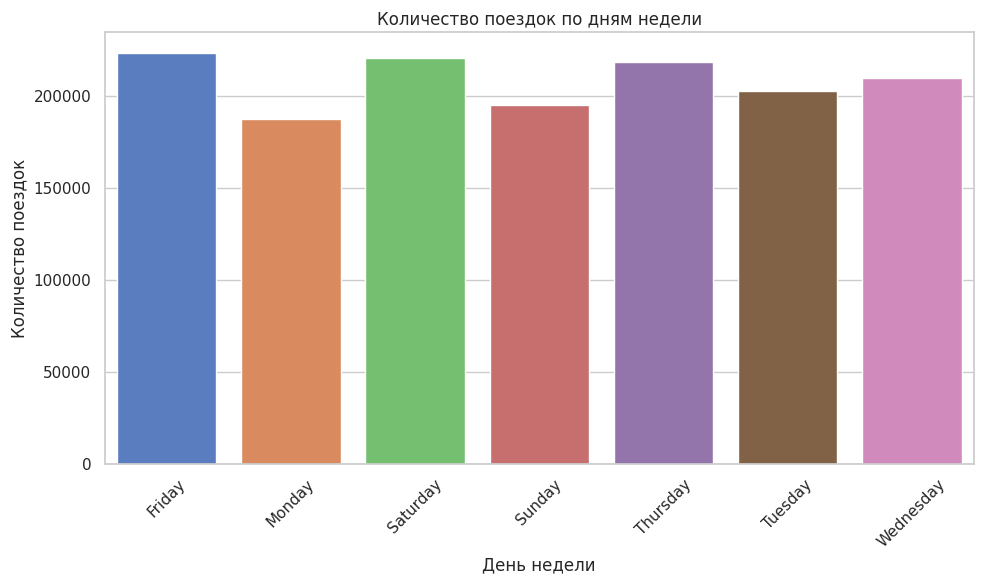

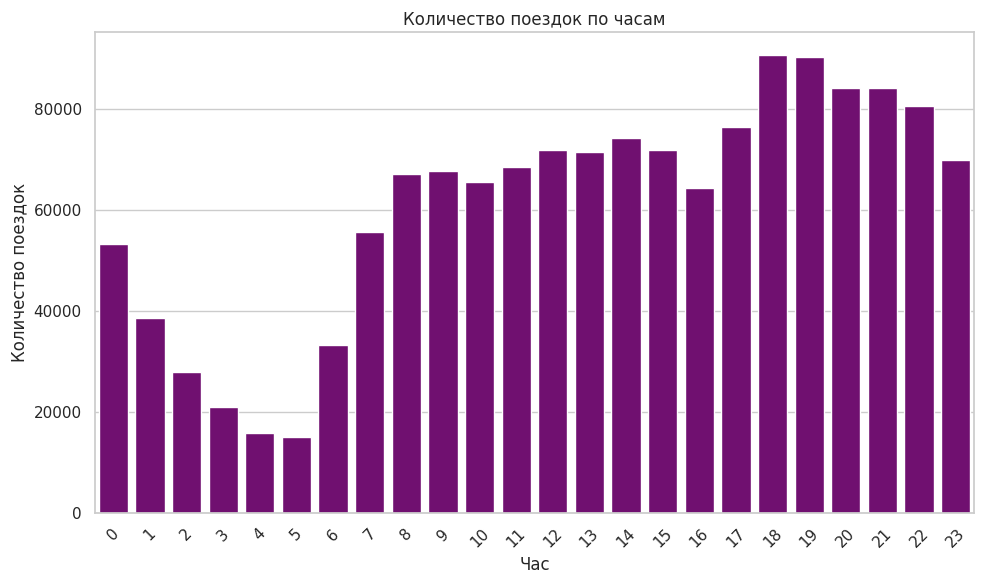

In [ ]:
fd_train['day_of_week'] = fd_train['pickup_datetime'].dt.day_name()
fd_train['hour'] = fd_train['pickup_datetime'].dt.hour

trips_by_day = fd_train.groupby('day_of_week').size().reset_index(name='trips')

trips_by_hour = fd_train.groupby('hour').size().reset_index(name='trips')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=trips_by_day, x='day_of_week', y='trips', palette='muted')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=trips_by_hour, x='hour', y='trips', color='purple')
plt.title('Количество поездок по часам')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Задание 3 [+0.25 балла]**. Постройте график, на котором будет отображена зависимость числа поездок от времени суток для различных месяцев. Используйте разные цвета для кривых, соответствующих разным месяцам, с помощью параметра `hue` в `sns.relplot`. Аналогичным образом постройте график, показывающий зависимость количества поездок от часа в сутках для разных дней недели.

Это важно по нескольким причинам:

1. **Выявление временных закономерностей**: Графики помогут увидеть, как спрос на поездки меняется в течение суток в разные месяцы и дни недели. Это может выявить определенные тренды, например, пиковые часы поездок или временные периоды с низким спросом.

2. **Адаптация к сезонности и недельным циклам**: Понимание того, как спрос на поездки меняется в зависимости от времени года и дня недели, позволяет адаптировать модель машинного обучения и сделать правильный feature-engineering (правильную предобработку данных)




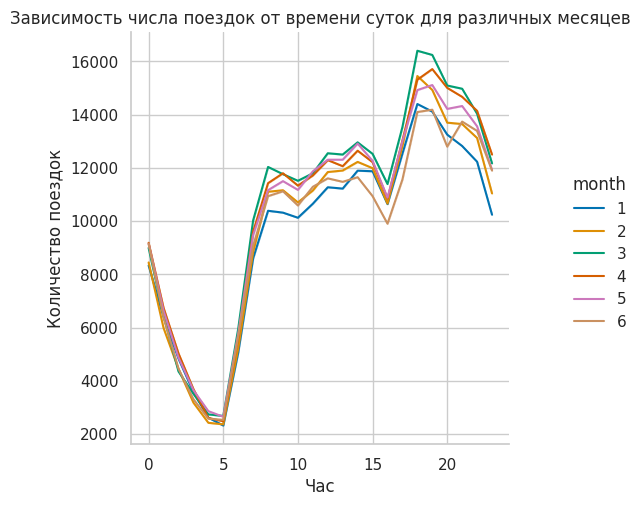

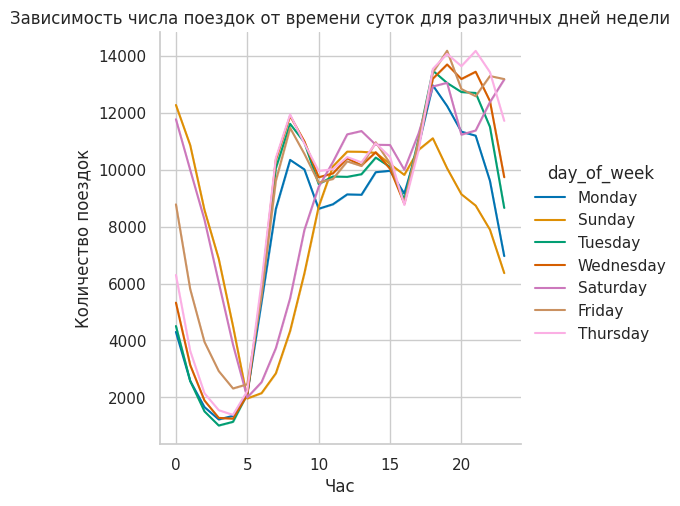

In [ ]:
fd_train['month'] = fd_train['pickup_datetime'].dt.month
fd_train['num_trips'] = fd_train.groupby(['month', 'hour'])['pickup_datetime'].transform('count')

sns.relplot(x='hour', y='num_trips', hue='month', kind='line', data=fd_train, palette='colorblind')
plt.title('Зависимость числа поездок от времени суток для различных месяцев')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.show()

#-----------------------------------------
fd_train['num_trips'] = fd_train.groupby(['day_of_week', 'hour'])['pickup_datetime'].transform('count')
sns.relplot(x='hour', y='num_trips', hue='day_of_week', kind='line', data=fd_train, palette='colorblind')
plt.title('Зависимость числа поездок от времени суток для различных дней недели')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.show()


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это может быть связано?

Больше всего поездок ночью сделано по субботам-воскресеньям(видимо связано с хорошо проведенными выходными)
Также в выходные дни и по понедельникам замечено снижение количества поездок в утренние часы
Самое большое количество поездок в четверг и пятницу,видимо, связано с концом рабочей недели

по месяцам количество поездок выглядит +- одинаково
видно падение в вечерние часы в январе, вероятно, связано с рождетсвенскими праздниками
пик зафиксирован в марте из-за смены погодных условий и возможного увеличения туристов

**Задание 4 [+0.25 балла]**. Разделите данные на обучающую и тестовую выборки в соотношении 80:20 с помощью функции `train_test_split` из библиотеки `sklearn`. На основе обучающей выборки постройте график, показывающий зависимость логарифма среднего времени поездки от дня недели. Повторите этот процесс для часа в сутках и дня в году.

Посмотреть график распределения тренировочной выборки важно по нескольким причинам:

1. **Понимание данных**: Анализ тренировочной выборки помогает лучше понять распределение и характеристики данных, что важно для выбора и настройки моделей машинного обучения

2. **Выявление закономерностей**: Графики зависимостей могут выявить важные закономерности и тренды в данных, которые могут быть использованы для улучшения моделей прогнозирования.

3. **Избежание переобучения**: Анализируя только тренировочную выборку, мы избегаем риска "заглядывания в будущее" и переобучения модели, когда она слишком хорошо подгоняется под тестовые данные.


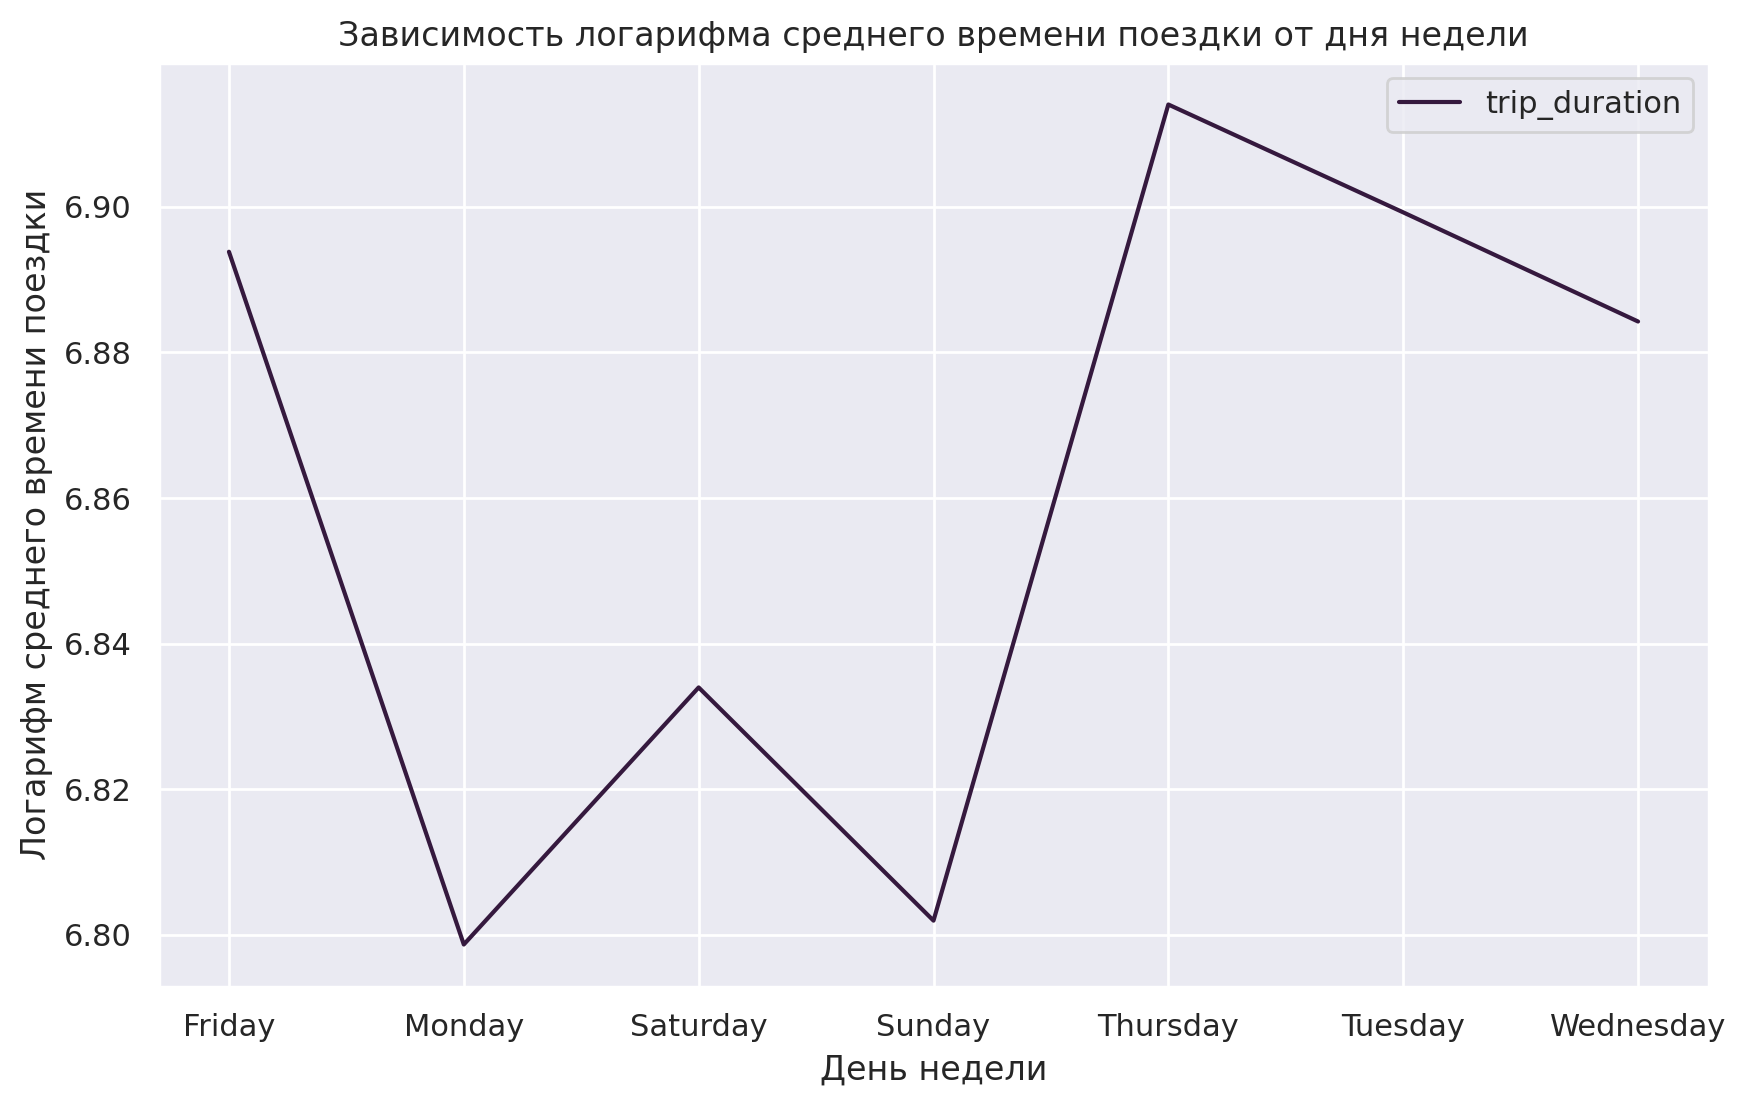

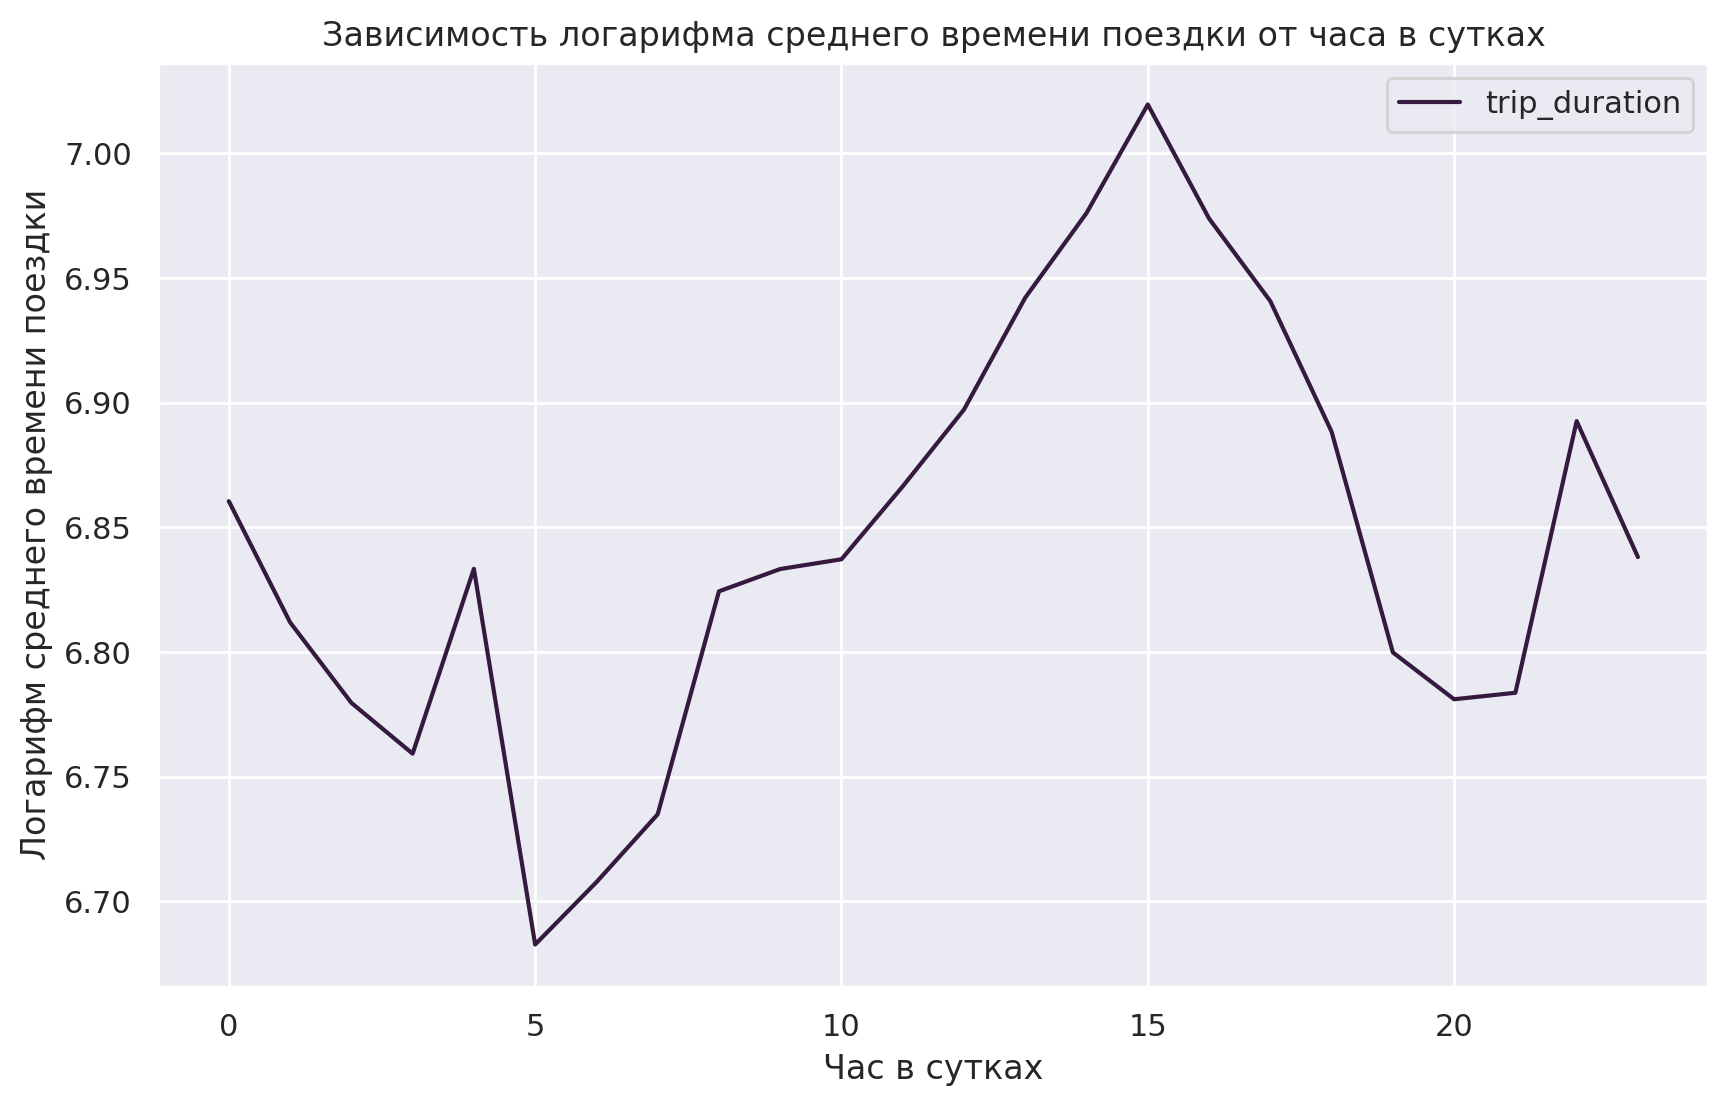

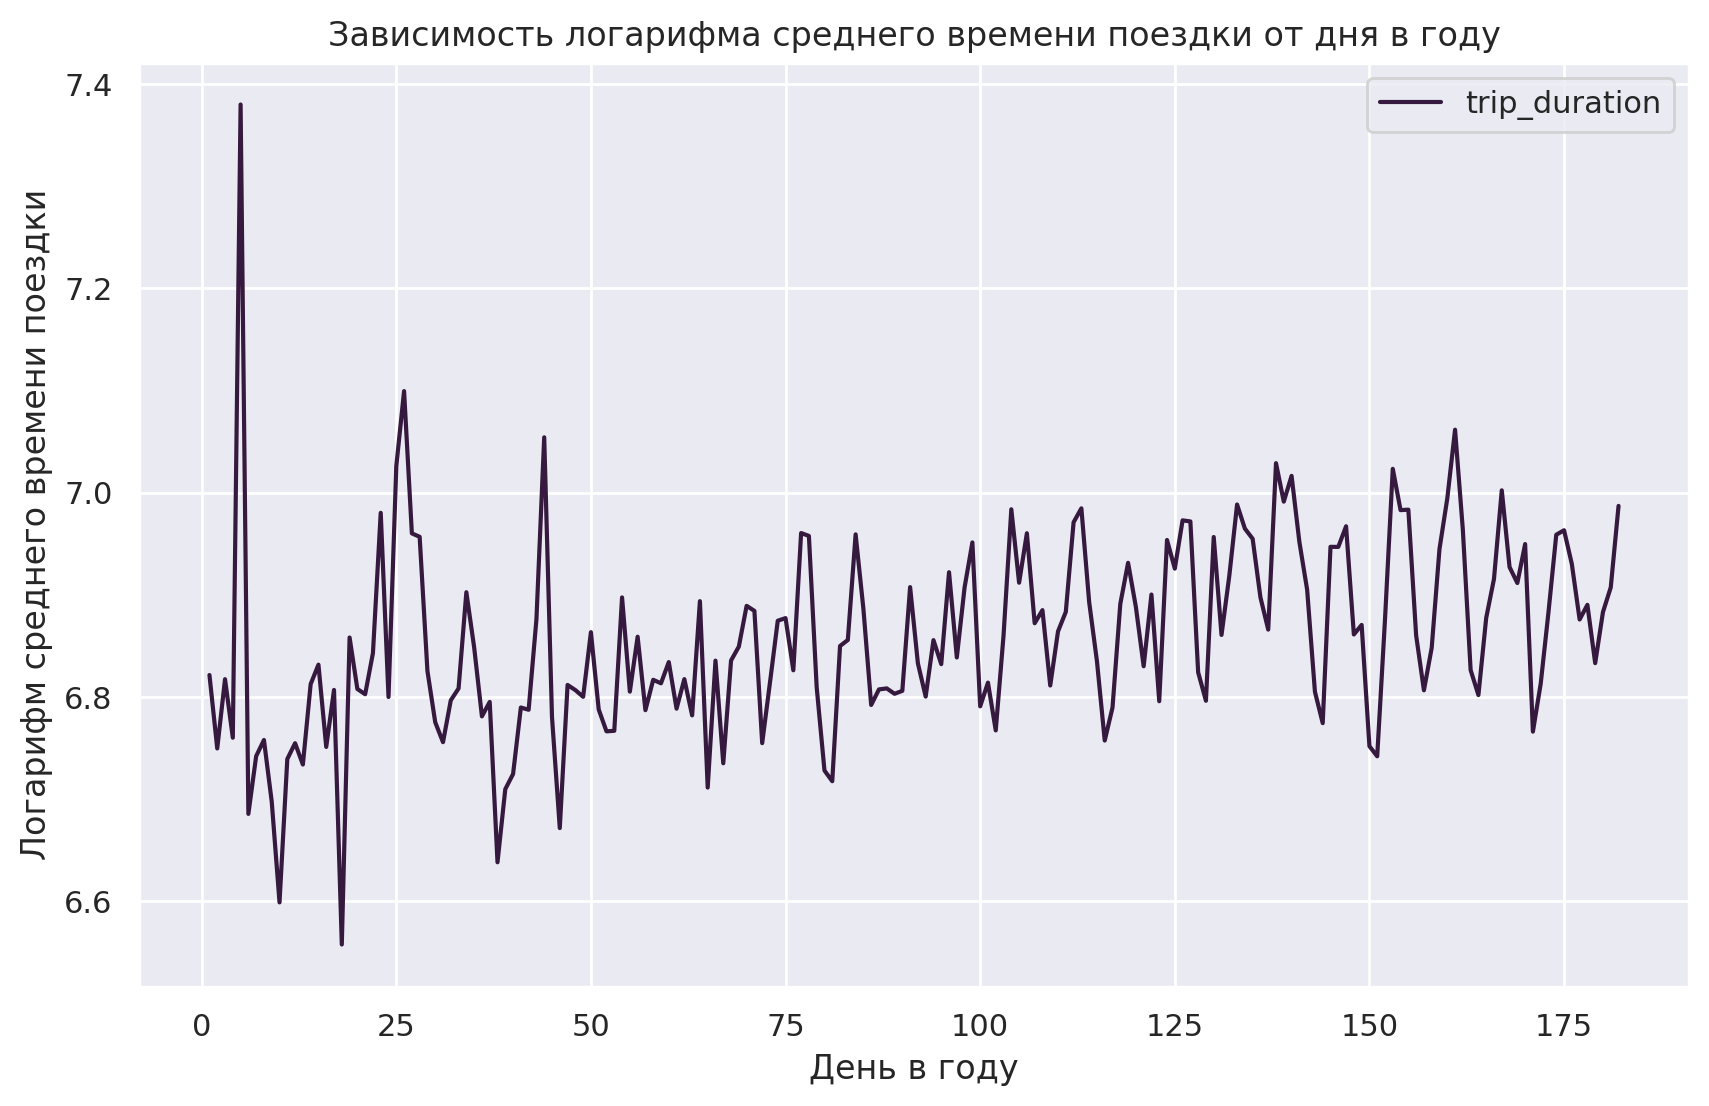

In [ ]:
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='rocket')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

fd_train['day_of_week'] = fd_train['pickup_datetime'].dt.day_name()
fd_train['hour_of_day'] = fd_train['pickup_datetime'].dt.hour
fd_train['day_of_year'] = fd_train['pickup_datetime'].dt.dayofyear

train_data, test_data = train_test_split(fd_train, test_size=0.2, random_state=42)

mean_trip_duration_dow = train_data.groupby('day_of_week')['trip_duration'].agg(np.mean).apply(np.log).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax = mean_trip_duration_dow.plot(x='day_of_week', y='trip_duration', ax=ax)
ax.set_xlabel('День недели')
ax.set_ylabel('Логарифм среднего времени поездки')
ax.set_title('Зависимость логарифма среднего времени поездки от дня недели')
plt.show()

mean_trip_duration_hour = train_data.groupby('hour_of_day')['trip_duration'].agg(np.mean).apply(np.log).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax = mean_trip_duration_hour.plot(x='hour_of_day', y='trip_duration', ax=ax)
ax.set_xlabel('Час в сутках')
ax.set_ylabel('Логарифм среднего времени поездки')
ax.set_title('Зависимость логарифма среднего времени поездки от часа в сутках')
plt.show()

# Для дня в году
mean_trip_duration_day = train_data.groupby('day_of_year')['trip_duration'].agg(np.mean).apply(np.log).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax = mean_trip_duration_day.plot(x='day_of_year', y='trip_duration', ax=ax)
ax.set_xlabel('День в году')
ax.set_ylabel('Логарифм среднего времени поездки')
ax.set_title('Зависимость логарифма среднего времени поездки от дня в году')
plt.show()

#print(fd_train['day_of_year'].min())  # Выведет минимальный день года
#print(fd_train['day_of_year'].max())  # Выведет максимальный день года


╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

Добавьте следующие признаки на основе `pickup_datetime` (не зря мы преобразовывали это в первых этапах):
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

Разбиение даты на отдельные признаки важно по нескольким причинам:

1. **Выявление временных закономерностей**: Разделение даты на день недели, месяц и час помогает выявить закономерности в данных, связанные с временем суток, днями недели и сезонностью.

2. **Улучшение прогностической способности модели**: Добавление этих признаков может улучшить точность моделей машинного обучения, поскольку они могут захватывать важные временные зависимости в данных.

3. **Адаптация к аномальным событиям**: Бинарные признаки, указывающие на аномальные периоды, позволяют модели учитывать особые ситуации, которые могут существенно отличаться от обычных условий.

4. **Повышение интерпретируемости**: Разбиение даты на отдельные компоненты делает модель более интерпретируемой, позволяя легче понять, как различные временные факторы влияют на целевую переменную.

In [ ]:
fd_train['day_of_week'] = fd_train['pickup_datetime'].dt.day_name()
fd_train['hour_of_day'] = fd_train['pickup_datetime'].dt.month
fd_train['day_of_year'] = fd_train['pickup_datetime'].dt.dayofyear
fd_train['hour_of_day'] = fd_train['pickup_datetime'].dt.hour

q1 = fd_train['trip_duration'].quantile(0.25)
q3 = fd_train['trip_duration'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

fd_train['is_anomaly'] = ((fd_train['trip_duration'] < lower) | (fd_train['trip_duration'] > upper)).astype(int)
#d_train['is_anomaly']

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

"day_of_week", "month", "is_anomaly"(т.к бинарный) - категориальные признаки, так как указывают на категориальные признаки. (Название месяца, название дня недели). "day_of_year" - можно считать численным признаком, так как представляет номер дня в году.
"trip_duration" и "hour" - также численные признаки.

In [ ]:
fd_train = fd_train.drop('hour_of_day', axis=1)

In [ ]:
fd_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year,day_of_week,hour,month,num_trips,is_anomaly
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,74,Monday,17,3,10857,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,164,Sunday,0,6,12270,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,19,Tuesday,11,1,9759,1
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,97,Wednesday,19,4,13693,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,86,Saturday,13,3,11355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,99,Friday,13,4,10128,0
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,10,Sunday,7,1,2844,0
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,113,Friday,6,4,5544,0
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,5,Tuesday,15,1,10096,0


**Задание 5 [+0.375 балла]**.
Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили в этой части задания. Замерьте качество на тестовой выборке (RMSLE)

Применение `OneHotEncoder` и `StandardScaler` важно по следующим причинам:

1. **OneHotEncoder для категориальных признаков**: Категориальные признаки необходимо преобразовать в числовой формат перед использованием в линейной регрессии. `OneHotEncoder` преобразует категориальные переменные в бинарные векторы, что позволяет модели корректно интерпретировать эти признаки без внесения искажений, связанных с порядком значений.

2. **StandardScaler для численных признаков**: Масштабирование численных признаков с помощью `StandardScaler` помогает стандартизировать данные, приводя их к одному масштабу с нулевым средним и единичным стандартным отклонением. Это улучшает интерпретацию весов линейной модели (а также мы обсудим на лекции, почему это ускоряет обучение модели)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

In [ ]:
categorical_features = ['day_of_week', 'hour', 'month']
numerical_features = ['log_trip_duration','day_of_year', 'num_trips']

In [ ]:
print(fd_train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
log_trip_duration     0
day_of_year           0
day_of_week           0
hour                  0
month                 0
num_trips             0
is_anomaly            0
dtype: int64


In [ ]:
target = fd_train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(fd_train[categorical_features + numerical_features], target, test_size=0.5, random_state=42)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [ ]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

In [ ]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_trip_duration',
                                                   'day_of_year',
                                                   'num_trips']),
                                                 ('cat', OneHotEncoder(),
                                                  ['day_of_week', 'hour',
                                                   'month'])])),
                ('regressor', Ridge())])

In [ ]:
y_pred = ridge_pipeline.predict(X_test)
y_pred = np.maximum(y_pred, 1)


In [ ]:
y_test_log = np.log1p(y_test)
y_pred_log = np.log1p(y_pred)
y_pred = np.maximum(y_pred, 1)


rmsle_value = rmsle(y_test_log, y_pred_log)
print(rmsle_value)

2.2715799890107387


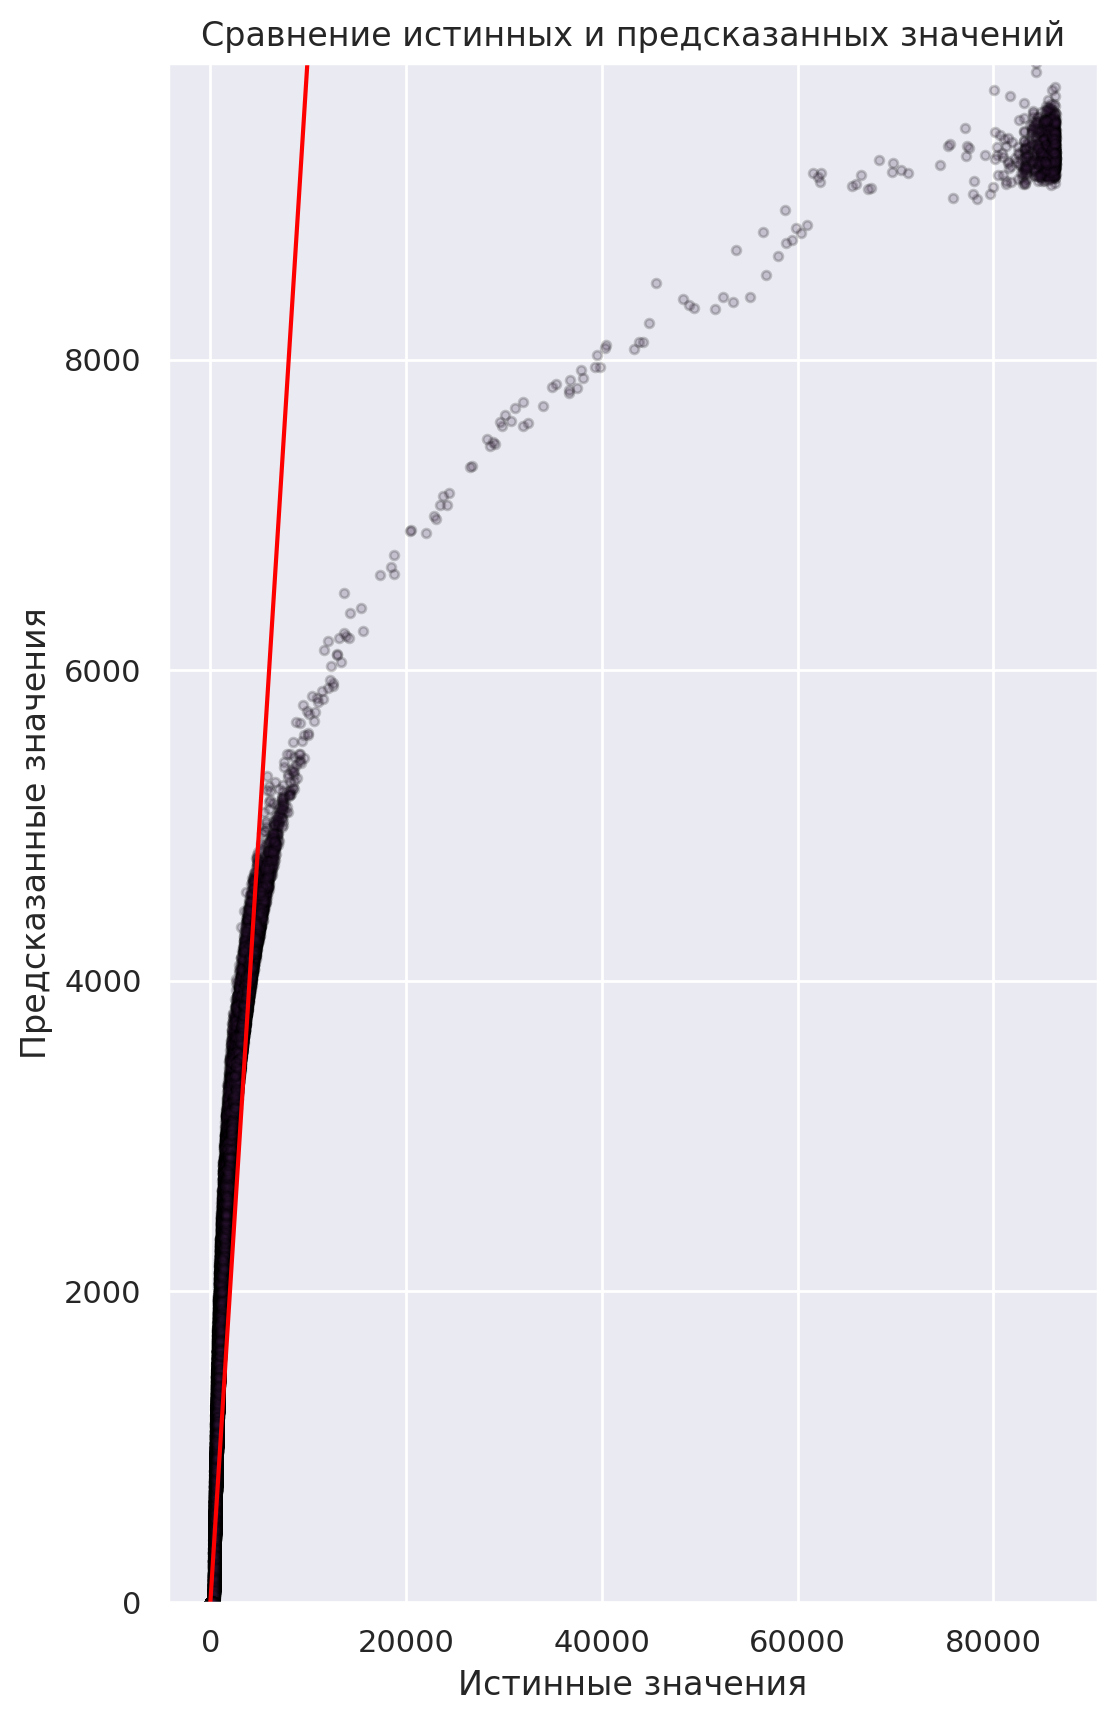

In [ ]:
plt.figure(figsize=(6, 10))  # Увеличение высоты фигуры
plt.scatter(y_test, y_pred, alpha=0.2, s=10, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.ylim(min(y_pred) - 5, max(y_pred) + 5)  # Расширение пределов оси Y
plt.show()

## Часть 2. Изучаем координаты & Обучаем модель [+1.5 балла]




Теперь, когда мы подробно изучили временные аспекты данных о поездках, давайте переключим наше внимание на географические данные, а именно на координаты начала и конца поездок. Мы предоставили вам функцию, которая отображает на карте точки начала или конца поездок. Однако обратите внимание, что для эффективности этой функции мы используем только небольшой фрагмент данных, иначе обработка займет слишком много времени.

Анализ координат важен по нескольким причинам:

1. **Пространственный анализ**: Координаты позволяют проводить пространственный анализ, который может выявить географические закономерности в данных, такие как популярные места отправления и назначения, районы с высоким спросом и т. д.

2. **Улучшение точности прогнозов**: Включение географических признаков в модели прогнозирования может повысить их точность, поскольку координаты могут быть связаны с различными факторами, влияющими на длительность поездок и спрос на транспортные услуги.

In [ ]:
import folium
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    Рисует карту с кругами, представляющими точки данных.

    Параметры
    ----------
    data : DataFrame
        DataFrame, содержащий колонки с широтой и долготой.
    latitude_column : str
        Название колонки в DataFrame, содержащей координаты широты.
    longitude_column : str
        Название колонки в DataFrame, содержащей координаты долготы.
    color : str
        Цвет кругов, которые будут нарисованы на карте.

    Возвращает
    -------
    folium.Map
        Объект карты Folium с нарисованными кругами в указанных координатах.

    Примеры
    --------
    >>> import pandas as pd
    >>> data = pd.DataFrame({
    ...     'latitude': [37.773972, 37.774159],
    ...     'longitude': [-122.431297, -122.431297]
    ... })
    >>> show_circles_on_map(data, 'latitude', 'longitude', 'blue')
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(fd_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(fd_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Необходимо взять во внимание скопление точек около базы гидросамолетов(Edo Seaplane Base), так как это место может иметь повышенный спрос в связи с труднодоступностью(возможной) и важностью объектов, находящихся там. Также стоит рассмотреть скопление точек около национальной области, потому что природные туричтические места как правило обладают бОльшим спросом.


**Задание 6 [+0.375 балла]**. Как нам хорошо известно, время поездки $t$ связано с расстоянием $s$ и средней скоростью $v_{\text{ср}}$ соотношением $t = s / v_{\text{ср}}$. Из этого следует, что расстояние между начальной и конечной точками поездки является одним из ключевых факторов, влияющих на время поездки. Хотя мы не можем точно определить полный маршрут, который преодолеет такси, мы можем оценить это расстояние, рассчитав кратчайшее расстояние между точками начала и конца поездки. Для корректного вычисления расстояния между двумя точками на поверхности Земли можно использовать функцию `haversine`. Рассчитайте кратчайшее расстояние для каждого объекта в данных и сохраните его в колонку `haversine`.

Это важно по нескольким причинам:

1. **Улучшение точности модели**: Включение расстояния как признака в модель может значительно улучшить точность прогнозирования времени поездки, поскольку оно напрямую влияет на длительность поездки.

2. **Понимание взаимосвязей**: Анализ зависимости времени поездки от расстояния может помочь выявить взаимосвязи и закономерности в данных, что полезно для понимания динамики транспортных потоков.


In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(row):
    R = 6371

    lt1 = radians(row['pickup_latitude'])
    ln1 = radians(row['pickup_longitude'])
    lt2 = radians(row['dropoff_latitude'])
    ln2 = radians(row['dropoff_longitude'])

    dlon = ln2 - ln1
    dlat = lt2 - lt1

    a = sin(dlat / 2)**2 + cos(lt1) * cos(lt2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    return R * c


fd_train['haversine'] = fd_train.apply(haversine, axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
fd_train['haversine'] = fd_train['haversine'].replace(0, 1e-8)
fd_train['log_haversine'] = np.log(fd_train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
from scipy.stats import pearsonr

corr_haversine, _ = pearsonr(fd_train['haversine'], fd_train['trip_duration'])
corr_log_haversine, _ = pearsonr(fd_train['log_haversine'], fd_train['log_trip_duration'])

print(f"Коэффициент корреляции Пирсона для haversine: {corr_haversine}")
print(f"Коэффициент корреляции Пирсона для log_haversine: {corr_log_haversine}") #т.к. коэф. пирсона близок к нулю, между переменными нет линейной связи


Коэффициент корреляции Пирсона для haversine: 0.11201953793268528
Коэффициент корреляции Пирсона для log_haversine: 0.5466951841833299


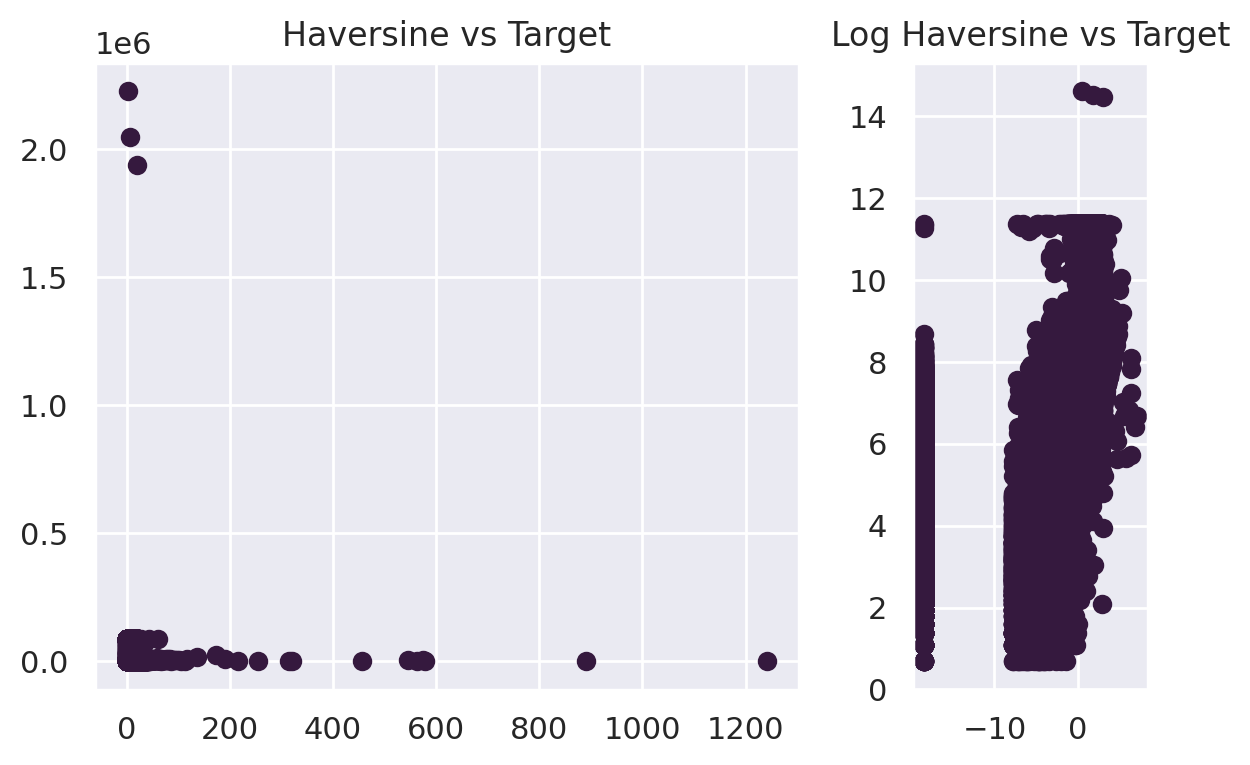

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [3, 1]})

axs[0].scatter(x='haversine', y='trip_duration', data=fd_train)
axs[0].set_title('Haversine vs Target')

axs[1].scatter(x='log_haversine', y='log_trip_duration', data=fd_train)
axs[1].set_title('Log Haversine vs Target')

plt.tight_layout()
plt.show()

По графику и коэф. Пирсона по логарифму(ближе к единице), видно, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние
по графикам это видно благодоря сгруппированности точек

**Задание 7 [+0.375 балла]**. Давайте проанализируем среднюю скорость движения такси. Для каждого объекта в обучающей выборке вычислите среднюю скорость, разделив значение в колонке `haversine` на значение в колонке `trip_duration`. Затем постройте гистограмму распределения полученных значений средней скорости.


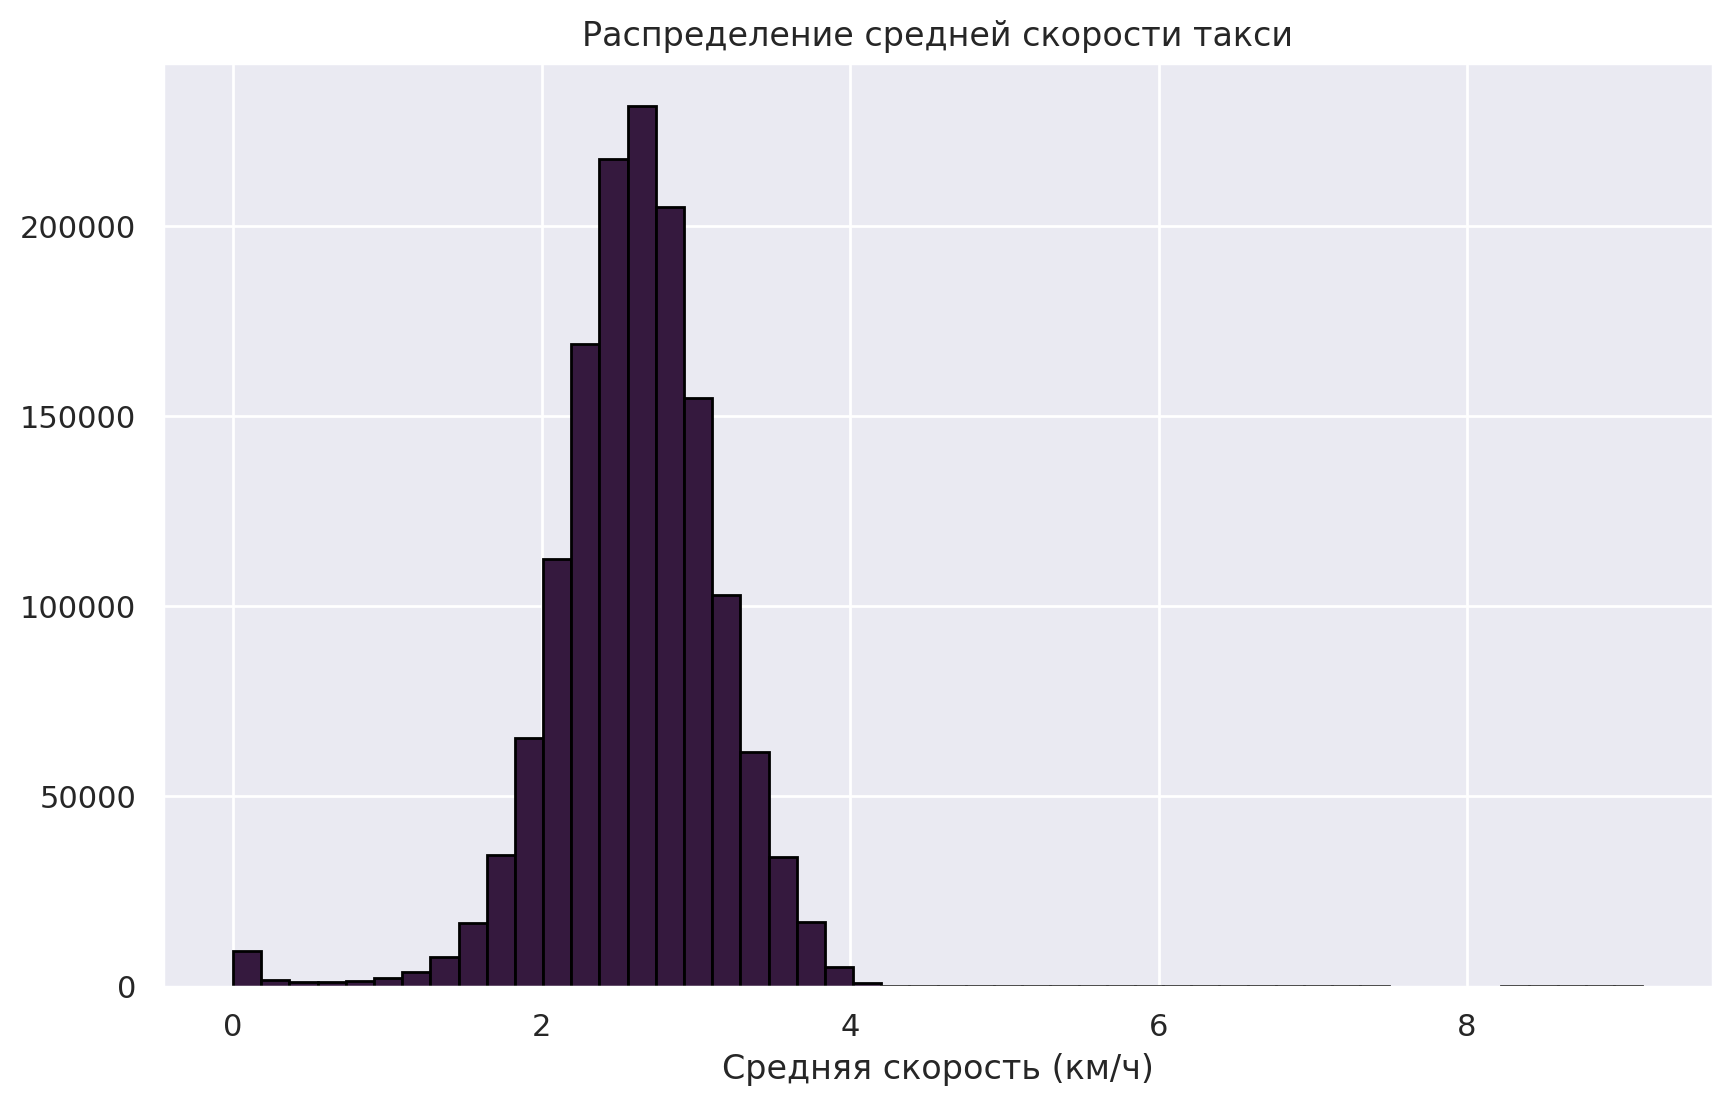

In [ ]:
fd_train['average_speed'] = fd_train['haversine'] / fd_train['trip_duration'] * 3600

plt.figure(figsize=(10, 6))
plt.hist(np.log1p(fd_train['average_speed']), bins=50, edgecolor='black')
plt.title('Распределение средней скорости такси')
plt.xlabel('Средняя скорость (км/ч)')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

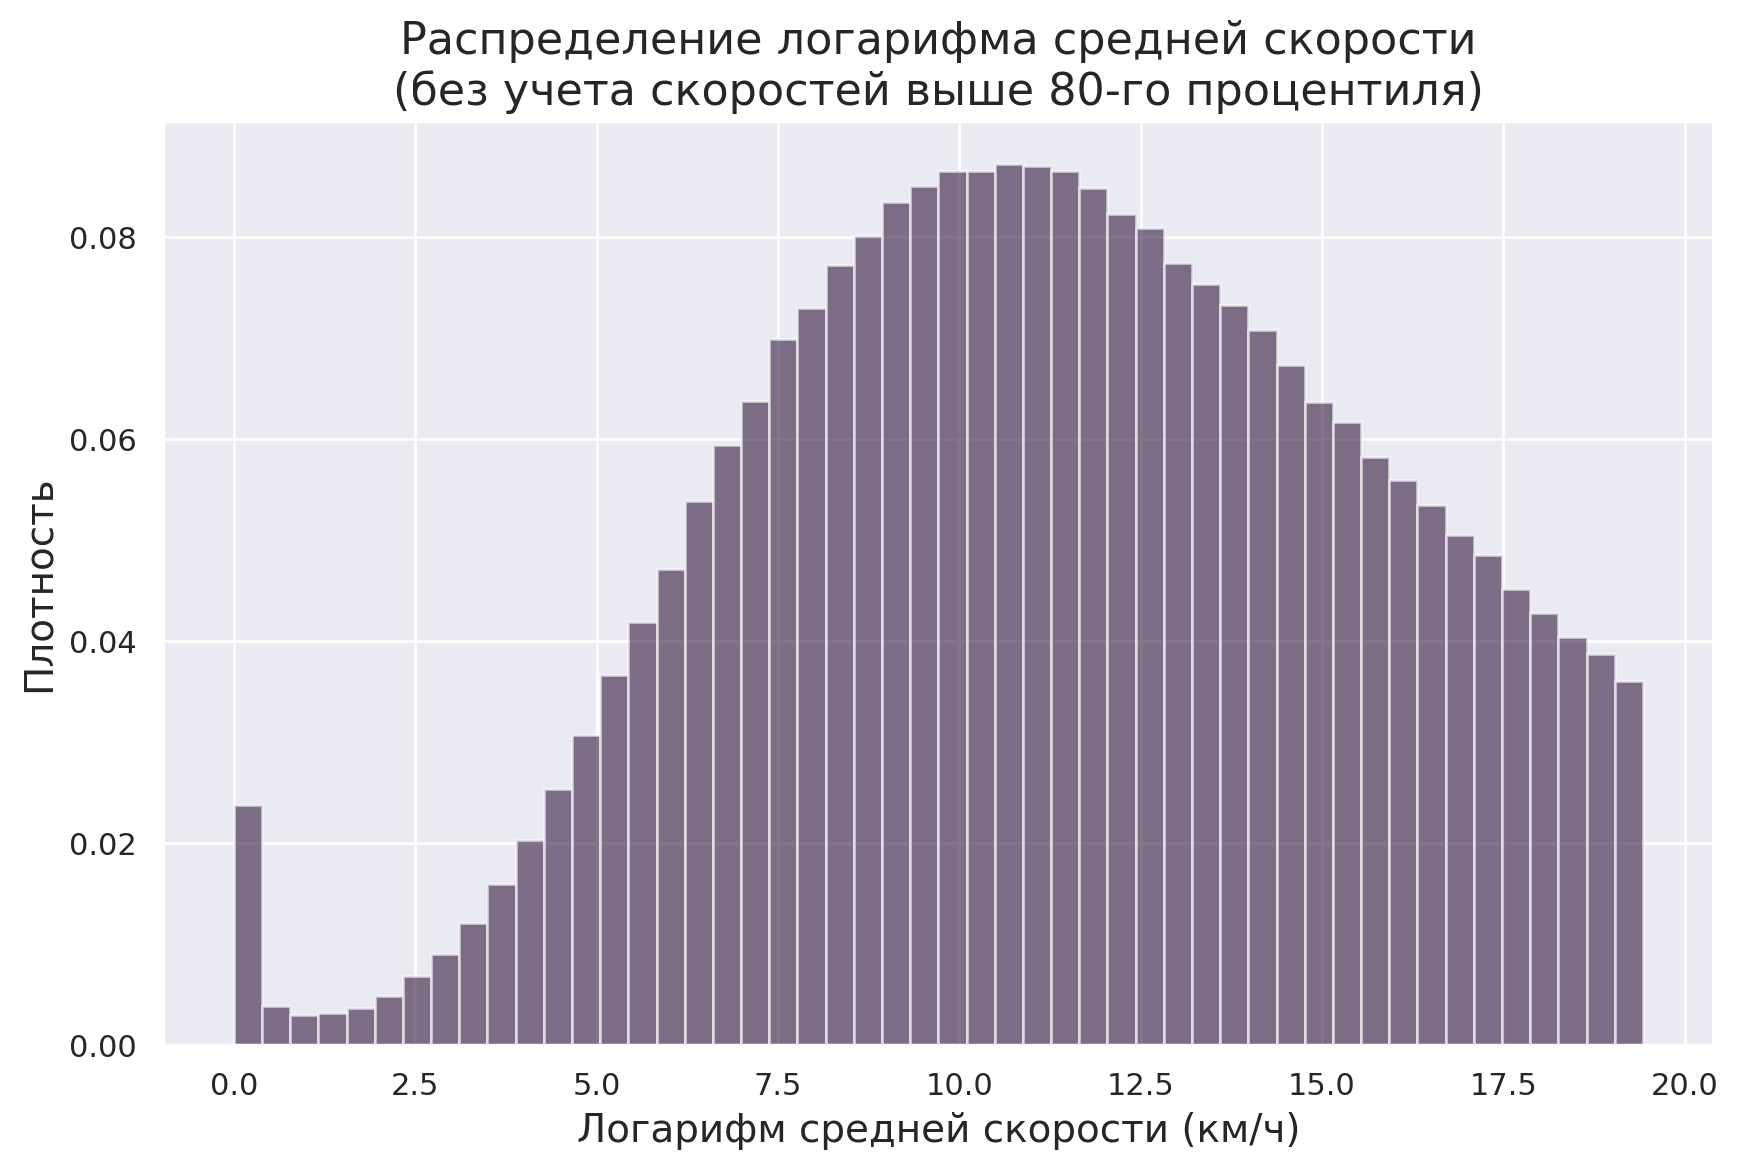

In [ ]:
limit = np.percentile(fd_train['average_speed'], 80)
reasonable_speeds = fd_train[fd_train['average_speed'] <= limit]

plt.figure(figsize=(10, 6))
plt.hist(reasonable_speeds['average_speed'], bins=50, density=True, alpha=0.6)
plt.title('Распределение логарифма средней скорости\n(без учета скоростей выше 80-го процентиля)', fontsize=16)
plt.xlabel('Логарифм средней скорости (км/ч)', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.show()
fd_train = fd_train.drop('average_speed', axis=1)


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Мы не знаем скорость до начала поездки
также на скорость влияет слишком много факторов, например, время суток, погодные условия и т.д
Также модель может усложниться без значительной прибавки к результату

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 8 [+0.625 балла]**. Сейчас мы практически не используем прямые значения координат в анализе. Это связано с тем, что широта и долгота по отдельности не несут значимой информации, а их взаимосвязь с целевой переменной нелинейна. Чтобы эффективно интегрировать координаты в наш анализ, мы можем применить следующий подход: окружим область с наибольшим количеством поездок прямоугольником и разделим этот прямоугольник на ячейки. Каждой точке присвоим номер ячейки, в которой она находится, а точкам вне прямоугольника присвоим значение -1.

Создайте трансформер, который вначале делит указанную область на ячейки, а затем генерирует два признака: номер ячейки начала поездки и номер ячейки конца поездки. Выбор количества строк и столбцов оставьте на ваше усмотрение.

Важно, чтобы все вычисления были векторизованными, трансформер не изменял исходный набор данных, а все необходимые статистики вычислялись только по обучающей выборке в методе `fit`.

Этот подход важен по следующим причинам:

1. **Учет пространственной структуры**: Разбиение на ячейки позволяет учесть пространственную структуру данных, что может улучшить качество анализа и прогнозирования.

2. **Снижение размерности**: Преобразование координат в номера ячеек уменьшает размерность данных, что упрощает анализ и сокращает время вычислений.

3. **Улучшение интерпретируемости**: Номера ячеек могут быть более интерпретируемыми, чем сырые координаты, что облегчает понимание взаимосвязей в данных.

4. **Адаптация к нелинейным зависимостям**: Такой подход позволяет адаптироваться к нелинейным зависимостям между координатами и целевой переменной, что может повысить точность моделей.

In [ ]:
fd_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_year,day_of_week,hour,month,num_trips,is_anomaly,haversine,log_haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,74,Monday,17,3,10857,0,1.498521,0.404478
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,164,Sunday,0,6,12270,0,1.805507,0.590842
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,19,Tuesday,11,1,9759,1,6.385098,1.853967
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,97,Wednesday,19,4,13693,0,1.485498,0.395750
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,86,Saturday,13,3,11355,0,1.188588,0.172766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,99,Friday,13,4,10128,0,1.225080,0.203006
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,10,Sunday,7,1,2844,0,6.049836,1.800031
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,113,Friday,6,4,5544,0,7.824606,2.057273
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,5,Tuesday,15,1,10096,0,1.092564,0.088527


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.patches as patches

class MapGridTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для преобразования географических координат в номера ячеек сетки.

    Параметры
    ----------
    n_rows : int
        Количество строк сетки.
    n_cols : int
        Количество столбцов сетки.
    lat_min : float
        Минимальная широта области.
    lat_max : float
        Максимальная широта области.
    lon_min : float
        Минимальная долгота области.
    lon_max : float
        Максимальная долгота области.

    Атрибуты
    ----------
    cell_size_lat : float
        Размер ячейки сетки по широте.
    cell_size_lon : float
        Размер ячейки сетки по долготе.

    Методы
    -------
    fit(X, y=None)
        Находит параметры сетки на основе данных.
    transform(X)
        Преобразует координаты в номера ячеек сетки.
    show_map()
        Отображает карту с ячейками сетки.
    """

    def __init__(self, n_rows, n_cols, lat_min, lat_max, lon_min, lon_max):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.cell_size_lat = None
        self.cell_size_lon = None

    def fit(self, X=None, y=None):
        """
        Находит параметры сетки на основе данных.

        Параметры
        ----------
        X : array-like, shape [n_samples, 2]
            Входные данные с координатами (широта, долгота).
        y : Ignored
            Не используется, существует для совместимости со стандартами sklearn.

        Возвращает
        -------
        self : object
            Возвращает себя.
        """
        lat_range = self.lat_max - self.lat_min
        lon_range = self.lon_max - self.lon_min
        self.cell_size_lat = lat_range / self.n_rows
        self.cell_size_lon = lon_range / self.n_cols
        return self

    def transform(self, X):
        """
        Преобразует координаты в номера ячеек сетки.

        Параметры
        ----------
        X : array-like, shape [n_samples, 2]
            Входные данные с координатами (широта, долгота).

        Возвращает
        -------
        X_transformed : array, shape [n_samples, 2]
            Преобразованные данные с номерами ячеек (номер строки, номер столбца).
        """
        in_bounds_lat = (X[:, 0] >= self.lat_min) & (X[:, 0] <= self.lat_max)
        in_bounds_lon = (X[:, 1] >= self.lon_min) & (X[:, 1] <= self.lon_max)
        in_bounds = in_bounds_lat & in_bounds_lon #проверка на вхождение в границы

        cell_row = ((X[:, 0] - self.lat_min) // self.cell_size_lat).astype(int)
        cell_col = ((X[:, 1] - self.lon_min) // self.cell_size_lon).astype(int) #преобразование координат в номера ячеек

        cell_numbers = np.where(in_bounds, cell_row * self.n_cols + cell_col, -1)
        X_transformed = cell_numbers.reshape(-1, 1)
        return X_transformed

    def show_map(self):
        """
        Отображает карту с ячейками сетки.
        """
        fig, ax = plt.subplots()

        for i in range(self.n_rows): #прямоугольники
            for j in range(self.n_cols):
                #считаем коорды
                bottom_left_lat = self.lat_min + i * self.cell_size_lat
                bottom_left_lon = self.lon_min + j * self.cell_size_lon
                rect = patches.Rectangle((bottom_left_lon, bottom_left_lat),
                                         self.cell_size_lon, self.cell_size_lat,
                                         linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        #пределы осей
        ax.set_xlim(self.lon_min, self.lon_max)
        ax.set_ylim(self.lat_min, self.lat_max)

        ax.set_xlabel('Долгота')
        ax.set_ylabel('Широта')
        ax.set_title('Карта с ячейками сетки')

        plt.show()

transformer = MapGridTransformer(n_rows=10, n_cols=10, lat_min=40.0, lat_max=41.0, lon_min=-74.0, lon_max=-73.0)



**Задание 9 [+0.125 балла]**. Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили до этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

numerical_features = ['log_trip_duration','day_of_year', 'hour', 'num_trips', 'log_haversine']
categorical_features = ['month', 'is_anomaly']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X = fd_train.drop('trip_duration', axis=1)
y = fd_train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

ridge_pipeline.fit(X_train, y_train)

y_pred = ridge_pipeline.predict(X_test)
y_pred = np.maximum(y_pred, 1)

y_test_log = np.log1p(y_test)
y_pred_log = np.log1p(y_pred)

rmsle_value = rmsle(y_test_log, y_pred_log)
print(rmsle_value)

2.302391157860981


## Часть 3. Изучаем оставшиеся признаки & Обучаем модель [+0.5 балла]


**Задание 10 [+0.375 балла]**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
unique_vendor_id = fd_train['vendor_id'].nunique()
unique_passenger_count = fd_train['passenger_count'].nunique()
unique_store_and_fwd_flag = fd_train['store_and_fwd_flag'].nunique()

print(f"vendor_id: {unique_vendor_id}")
print(f"passenger_count: {unique_passenger_count}")
print(f"store_and_fwd_flag: {unique_store_and_fwd_flag}")

vendor_id: 2
passenger_count: 10
store_and_fwd_flag: 2


vendor_id - может влиять на среднюю скорость(возможно это какое-то особое такси которое можно вызвать только ночью, собственно и приедем быстрее), тип вызываемых машин
passenger_count - может влиять на количество остановок и тип машины, то есть если в машине > 4 пассажиров, то она явно не легковая
store_and_fwd_flag - поездка может быть длительнее из-за проблем с GPS в начале поездки

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

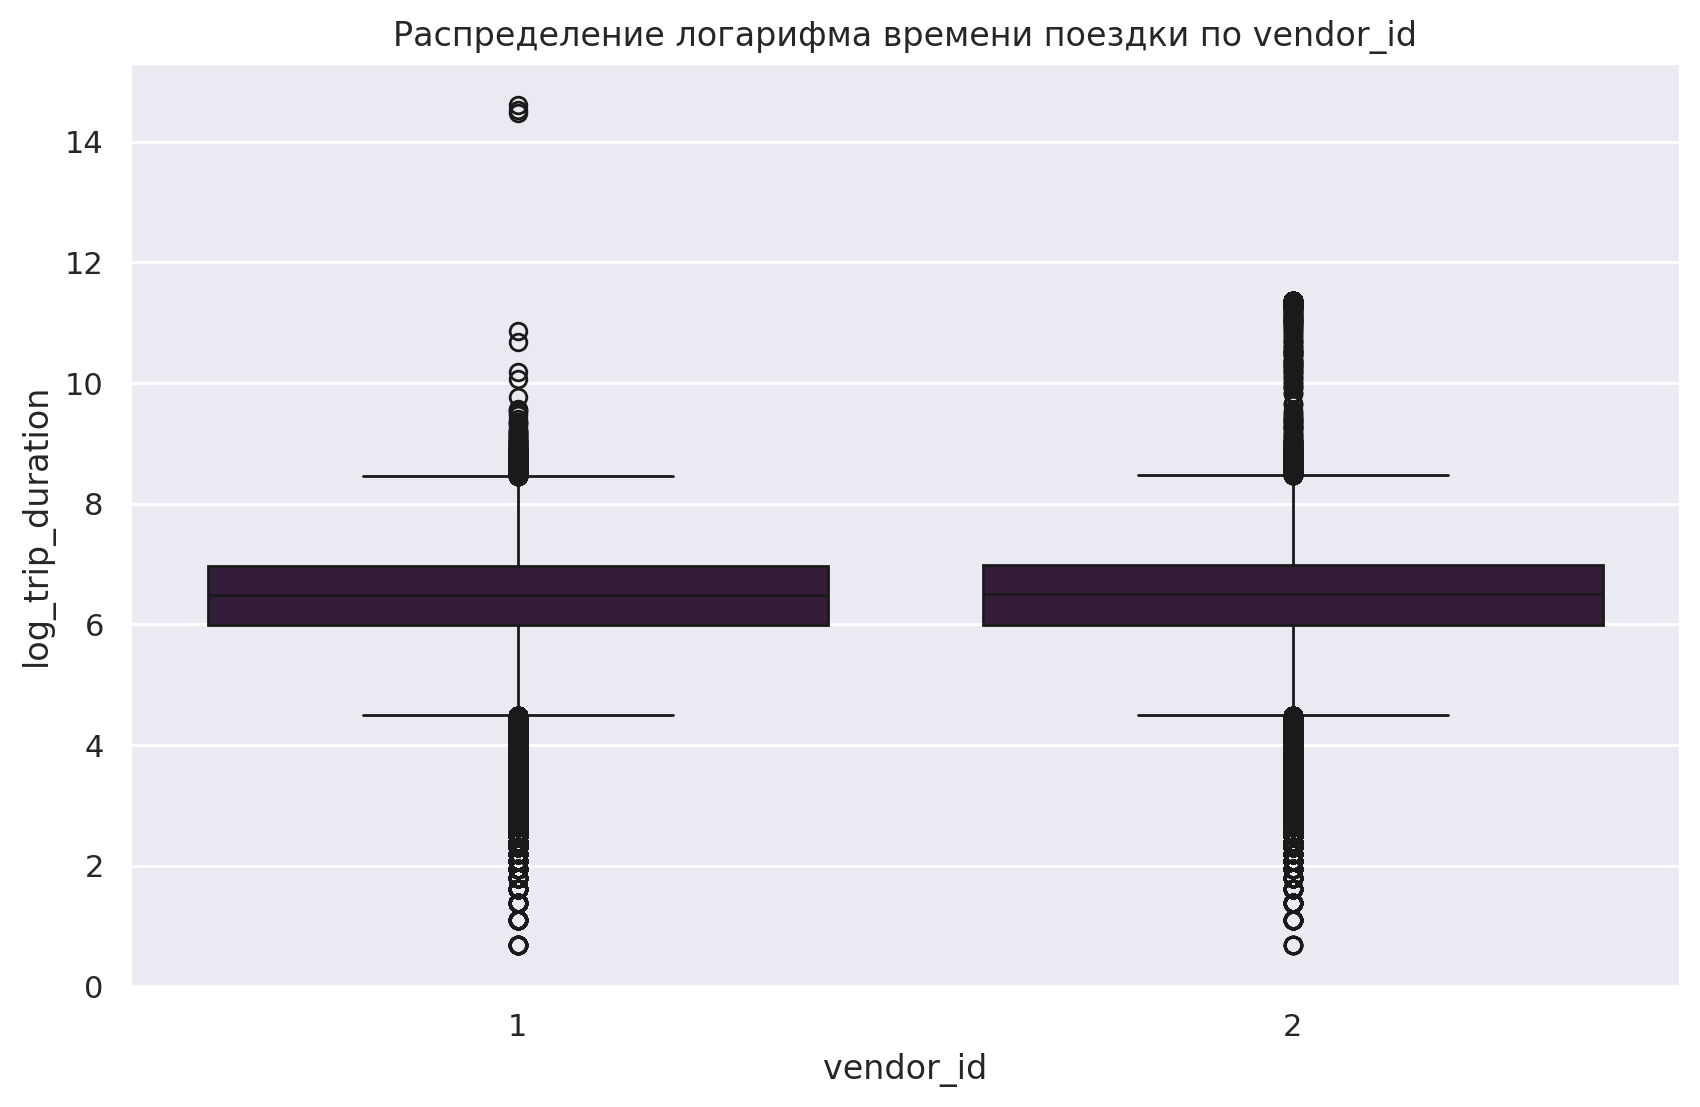

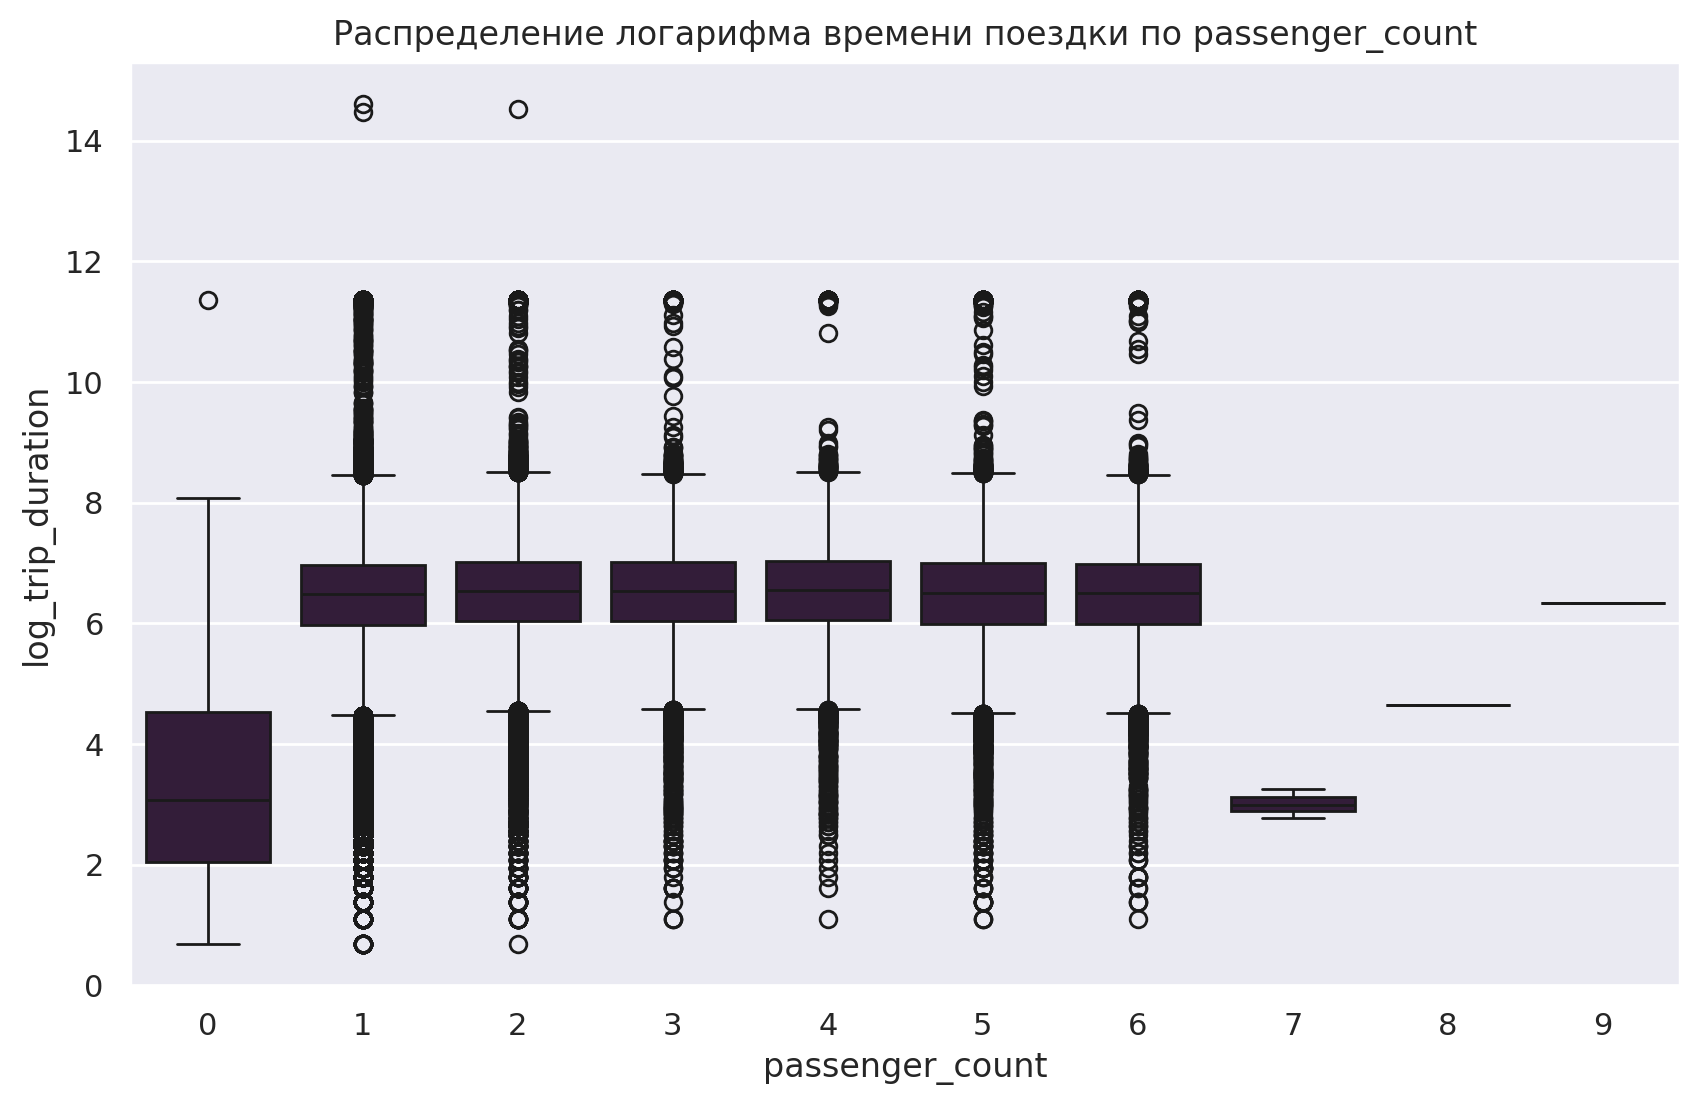

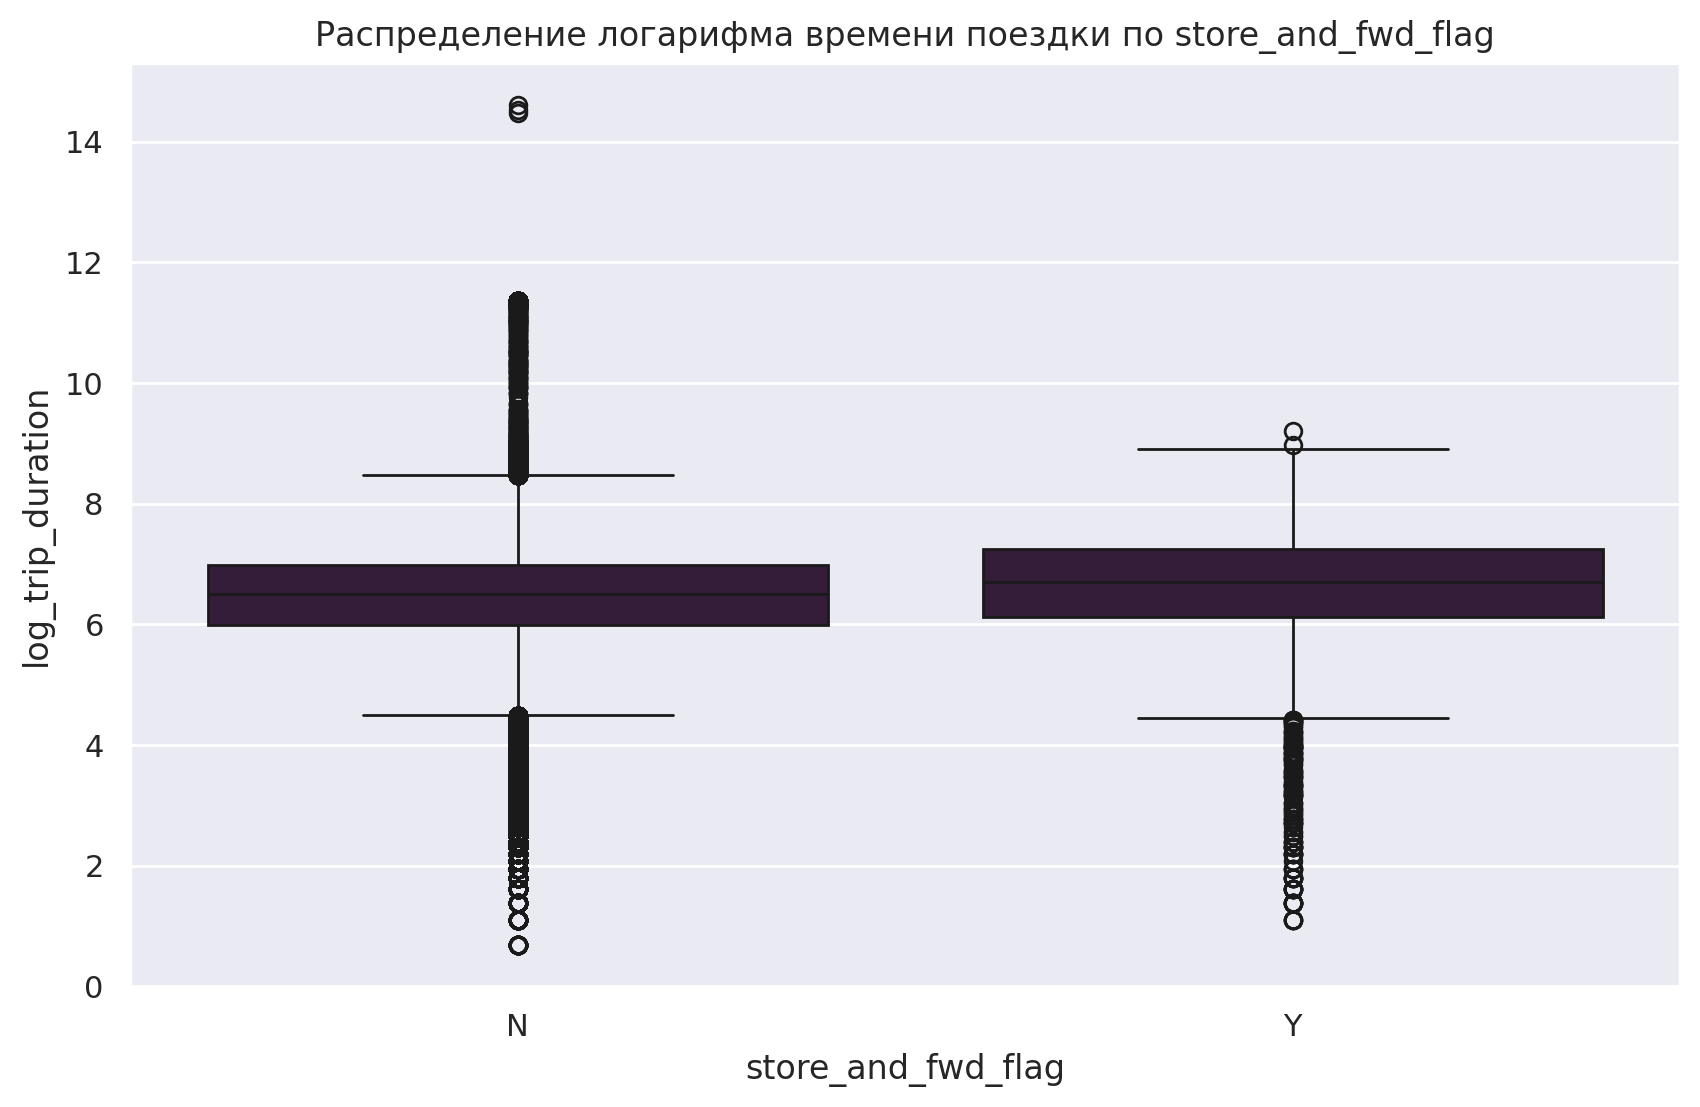

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='vendor_id', y='log_trip_duration', data=fd_train)
plt.title('Распределение логарифма времени поездки по vendor_id')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='log_trip_duration', data=fd_train)
plt.title('Распределение логарифма времени поездки по passenger_count')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=fd_train)
plt.title('Распределение логарифма времени поездки по store_and_fwd_flag')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
fd_train['vendor_id'] = fd_train['vendor_id'].replace({1: 0, 2: 1})
fd_train['store_and_fwd_flag'] = fd_train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})



In [ ]:
print(fd_train[['vendor_id', 'store_and_fwd_flag']].head())

   vendor_id  store_and_fwd_flag
0          1                   0
1          0                   0
2          1                   0
3          1                   0
4          1                   0


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Количество пассажиров не будет сильно влиять, так как для разного количества пассажиров, распределение времени поездки почти не различается.
store_and_fwd_flag будет влиять, потому что при значении 1 количество длинных поездок крайне мало по сравнению со значением 0.


**Задание 11 [+0.125 балла]**. Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы определили в этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:

categorical_features = ['day_of_year', 'day_of_week', 'hour', 'month']
binary_features = ['is_anomaly', 'vendor_id', 'store_and_fwd_flag']
numerical_features = ['log_trip_duration', 'num_trips', 'haversine', 'log_haversine', 'passenger_count']

X = fd_train[categorical_features + numerical_features + binary_features]
y = fd_train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)



y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 1)

fd_train.loc[X_test.index, 'predicted_trip_duration'] = y_pred

y_test_log = np.log1p(y_test) # Используйте log1p для предотвращения log(0)
y_pred_log = np.log1p(y_pred)

rmsle_value = rmsle(y_test_log, y_pred_log)
print(rmsle_value)


2.255146435051831


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель [+1.5 балла]

**Задание 12 [+0.5 балла]**. В нашем наборе данных присутствуют аномальные записи: объекты с необычно коротким временем поездки, слишком большим пройденным расстоянием или с большими остатками после регрессии. В этом задании предлагается исключить такие объекты из обучающего набора. Для этого постройте гистограммы распределения указанных величин, определите объекты, которые можно считать выбросами, и очистите __обучающий набор__ от них.

Следует отметить, что, несмотря на то что эти объекты кажутся выбросами, в тестовом наборе данных также могут присутствовать объекты с аналогичными аномальными значениями. Поэтому удаление выбросов из обучающего набора может привести к ухудшению качества на тестовом наборе. Однако, в целом, рекомендуется удалять выбросы из обучающего набора, чтобы получить более разумную и интерпретируемую модель.

Для определения выбросов можно использовать различные методы, такие как:

- **Z-оценка**: Выбросы определяются как объекты, у которых абсолютное значение Z-оценки (стандартизированное значение) превышает определенный порог (например, 3).

- **IQR (межквартильный размах)**: Выбросы определяются как объекты, значения которых выходят за пределы [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR], где Q1 и Q3 — первый и третий квартили соответственно.


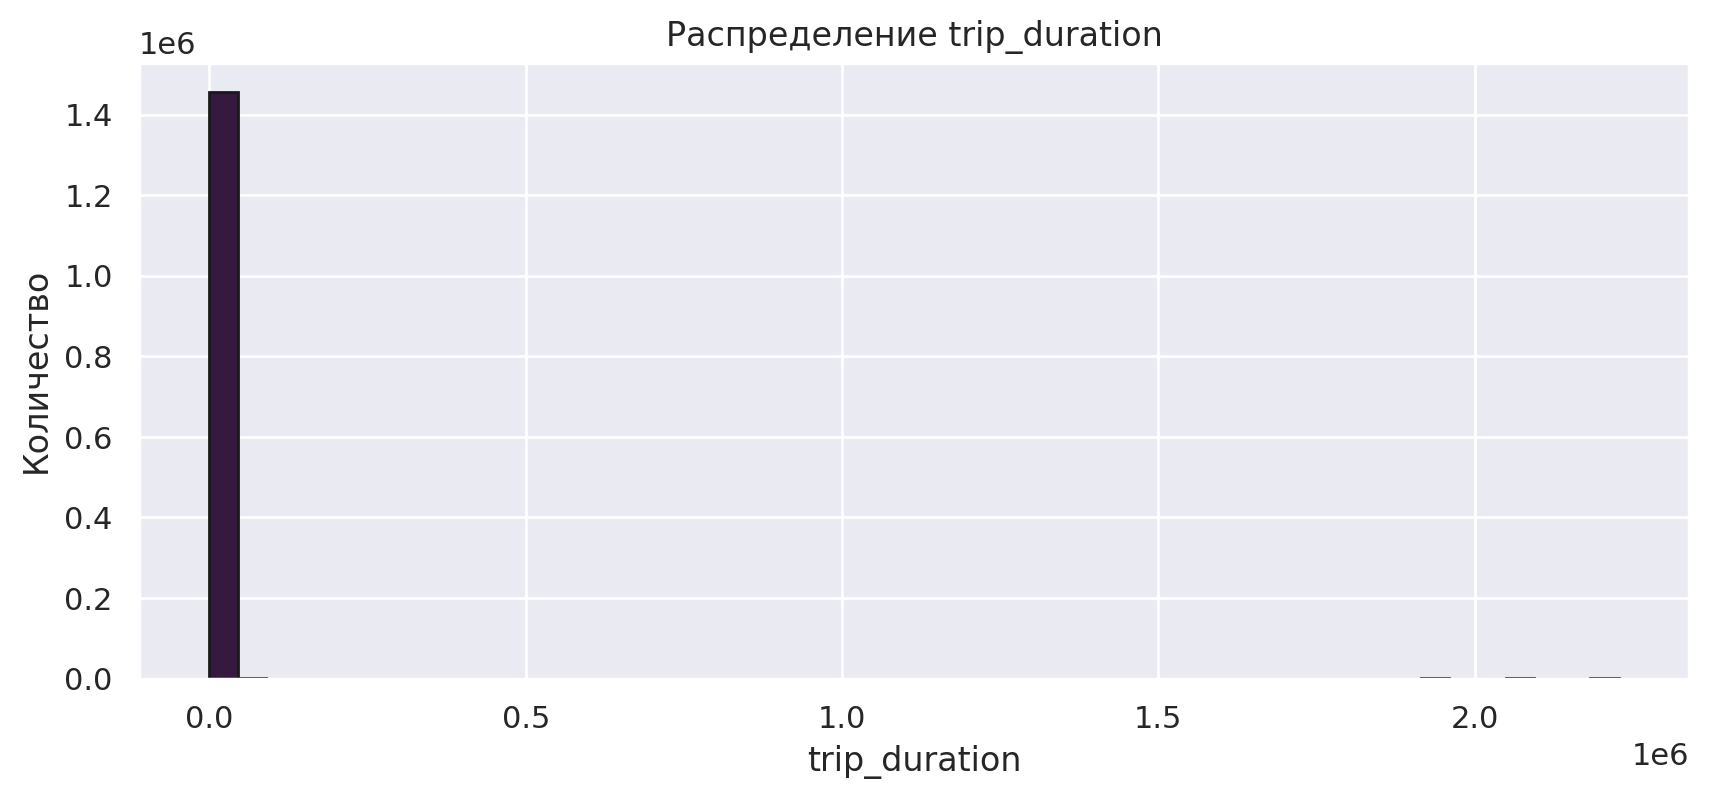

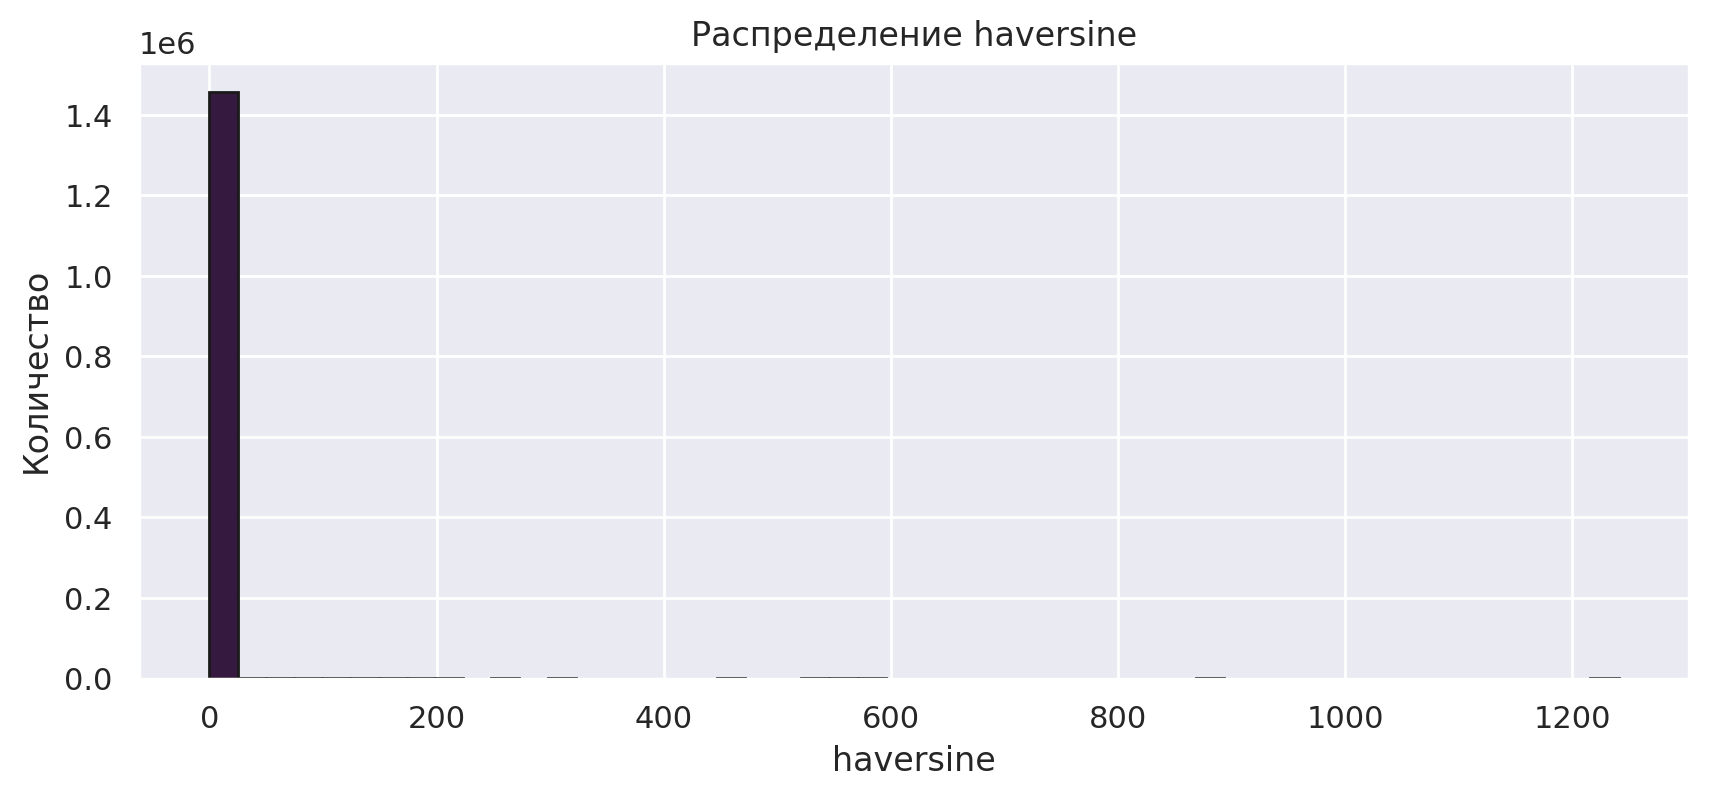

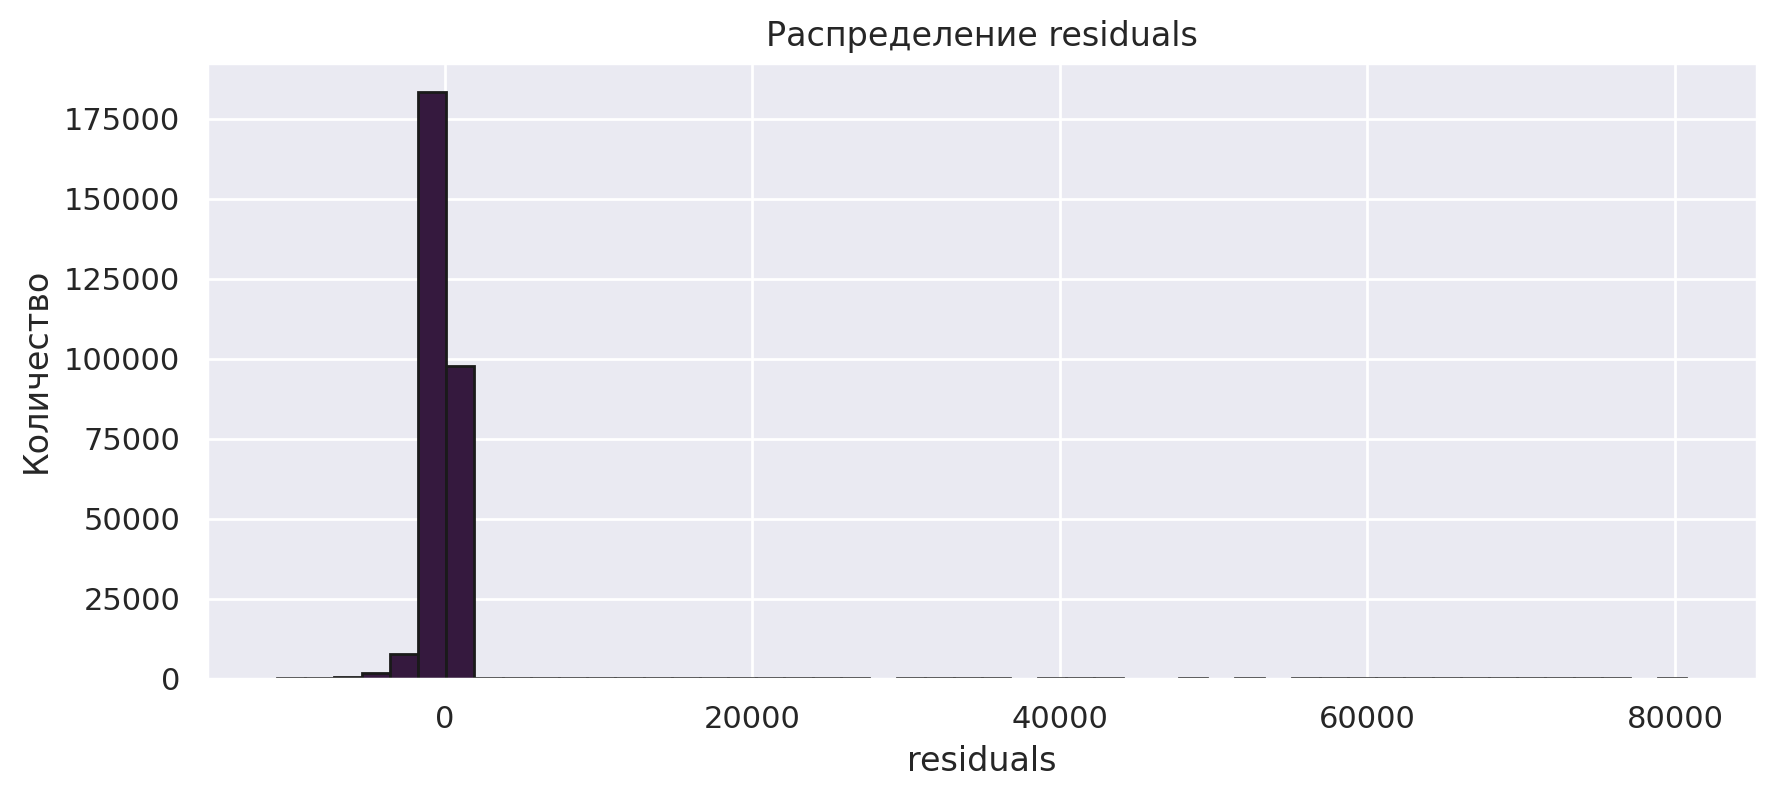

In [ ]:
fd_train['residuals'] = fd_train['trip_duration'] - fd_train['predicted_trip_duration'] #остатки после регрессии

features_to_plot = ['trip_duration', 'haversine', 'residuals']

for feature in features_to_plot:
    plt.figure(figsize=(10, 4))
    plt.hist(fd_train[feature], bins=50, edgecolor='k')
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.show()


In [ ]:
from scipy import stats

z_scores = np.abs(stats.zscore(fd_train[features_to_plot]))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

Q1 = fd_train[features_to_plot].quantile(0.25)
Q3 = fd_train[features_to_plot].quantile(0.75) #определение выбросов
IQR = Q3 - Q1
outliers_iqr = ((fd_train[features_to_plot] < (Q1 - 1.5 * IQR)) | (fd_train[features_to_plot] > (Q3 + 1.5 * IQR))).any(axis=1)

final_outliers = outliers | outliers_iqr #объединение результатов двух методов

cleaned_df = fd_train[~final_outliers]


In [ ]:
print(fd_train.shape[0] - cleaned_df.shape[0]) #количество удаленных строк

160214


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
threshold = 0.01
def replace_rare_categories(df, column, threshold):
    frequencies = fd_train[column].value_counts(normalize=True)
    rare = frequencies[frequencies < threshold].index
    fd_train[column] = fd_train[column].apply(lambda x: 'Other' if x in rare else x)
    return df

categorical_features = ['day_of_year', 'day_of_week', 'hour', 'month']

for column in categorical_features:
    fd_train = replace_rare_categories(fd_train, column, threshold)

Обучите регрессию `Ridge` с использованием параметров по умолчанию, применив `OneHotEncoder` для кодирования всех категориальных признаков и `StandardScaler` для масштабирования численных признаков (используйте `ColumnTransformer` и `PipeLine`. Ограничьтесь признаками, которые мы сделали до этой части задания. Замерьте качество на тестовой выборке (RMSLE)

In [ ]:
categorical_features = ['day_of_year', 'day_of_week', 'hour', 'month']
binary_features = ['is_anomaly', 'vendor_id', 'store_and_fwd_flag']
numerical_features = ['log_trip_duration', 'num_trips', 'haversine', 'log_haversine', 'passenger_count']

# Данные для обучения и тестирования
X = fd_train[categorical_features + numerical_features + binary_features]
y = fd_train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 1)

y_test_log = np.log1p(y_test)
y_pred_log = np.log1p(y_pred)



rmsle_value = rmsle(y_test_log, y_pred_log)
print(rmsle_value)


2.2520864840111474


**Задание 13 [+0.5 балла]**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
original_feature_count = len(categorical_features + numerical_features + binary_features)
print(f'Количество признаков до OneHot-кодирования: {original_feature_count}')

encoder = OneHotEncoder()
encoder.fit(fd_train[categorical_features])

encoded_feature_count = sum(len(categories) for categories in encoder.categories_)
total_feature_count = original_feature_count - len(categorical_features) + encoded_feature_count
print(f'Количество признаков после OneHot-кодирования: {total_feature_count}')

Количество признаков до OneHot-кодирования: 12
Количество признаков после OneHot-кодирования: 46


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso


model_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

model_lasso.fit(X_train, y_train)

y_pred_lasso = model_lasso.predict(X_test)

y_pred_lasso = np.maximum(y_pred, 1)

y_test_log = np.log1p(y_test)
y_pred_log = np.log1p(y_pred_lasso)



rmsle_value = rmsle(y_test_log, y_pred_log)
print(rmsle_value)



2.2520864840111474


По тренировочной выборке с помощью кросс-валидации (`zGridSearchCV`) подберите оптимальные значения параметра регуляризации (alpha, lambda в разных литературах по-разному) для `Ridge` и `Lasso` на тестовой выборке измерьте качество лучшей полученной модели.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 14 [+0.5 балла]**. Использование взаимодействия признаков часто оказывается полезным для улучшения качества модели. Мы уже разделили карту Манхэттена на ячейки и создали признаки, указывающие на ячейку начала и окончания поездки.

Теперь предлагается пойти дальше и посчитать, как часто встречается каждая возможная пара этих признаков в нашем наборе данных. Затем выберем 100 самых частых пар и закодируем поездки с этими парами как категориальный признак, а для остальных объектов установим значение -1. Таким образом, мы сможем кодировать информацию о маршруте поездки такси.

Создание таких признаков может быть круто по нескольким причинам:

1. **Улучшение предсказаний**: Комбинация начальной и конечной точек поездки может содержать важную информацию о времени поездки, которая поможет улучшить предсказательную способность модели.

2. **Выявление популярных маршрутов**: Анализ самых частых пар ячеек может помочь выявить наиболее популярные маршруты, что может быть полезно для планирования транспортных услуг.

3. **Интерпретируемость**: Новые признаки, основанные на маршрутах, могут улучшить интерпретируемость модели, позволяя лучше понять, как различные маршруты влияют на время поездки.

4. **Адаптация к специфике данных**: Такой подход позволяет адаптировать модель к специфике данных о поездках такси, учитывая географическую структуру города и особенности движения.

Также вы можете придумать другие способы создания признаков, связанных с маршрутом, которые могут дать дополнительные баллы при сдаче этого домашнего задания


In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Даже если линейная модель может выявить некоторые закономерности между начальной и конечной точками поездки, она может упустить нелинейные эффекты, связанные с расстоянием. Предоставление расстояния в качестве отдельного признака может помочь моделировать такие нелинейные зависимости.

Таким образом, включение расстояния в качестве отдельного признака может улучшить производительность линейной модели, обеспечить более эффективные вычисления, повысить интерпретируемость результатов и учесть возможные нелинейные эффекты, которые могут быть сложно выявить из начальной и конечной точек поездки.

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Часть 5. САМОЕ ВАЖНОЕ [+5 баллов]

Время соревнований. Кто сделает лучшую метрику RMSLE - тот победил. Разрешено использовать любые модели

RMSLE < 0.28 - 5 баллов

0.315 > RMSLE >= 0.28 - 4 балла

0.34 > RMSLE >= 0.315 - 3 балла

0.36 > RMSLE >= 0.34 - 2 балла

RMSLE > 0.36 - 0 баллов